In [4]:
import pandas as pd
import yfinance as yf
import numpy as np
import pandas as pd
import warnings as warns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize 
from datetime import datetime as dt
import warnings
warnings.filterwarnings("ignore")

# Dutch market sets gas prices for the whole of Europe

As gas prices continue to break all-time records across Europe, all eyes turn to the TTF, the continent's leading benchmark.

The Title Transfer Facility, more commonly known as TTF, is a virtual trading point for natural gas in the Netherlands. This trading point provides facility for a number of traders in Netherlands to trade futures, physical and exchange trades.

Set up by Gasunie in 2003, it is almost identical to the National Balancing Point (NBP) in the United Kingdom and allows gas to be traded within the Dutch Gas network. The TTF is operated by an independent subsidiary of Gasunie, Gasunie Transport Services B.V.,[1] which is the Gas Transmission System Operator in the Netherlands. Wholesale gas trading at the TTF is predominantly conducted over-the-counter via interdealer brokers. Physical short-term gas and gas futures contracts are also traded and handled by the ICE-Endex Exchange (Amsterdam[2]) and via the PEGAS exchange. Gas at TTF trades in euros per megawatt hour.

In the two decades since its inception trades at the TTF have grown exponentially and exceeded domestic volumes in the Netherlands fourteen-fold. This increase, helped by the rise of liquefied natural gas (LNG), caused the TTF to overtake the UK's National Balancing Point (NBP) as Europe's biggest gas benchmark.[3]

As in any other free marketplace, prices on the Dutch hub are determined by the fundamental economic rules of supply and demand.

Products are invoiced in euros per megawatt-hour.

#### Speculation fuels prices
The TTF offers two main options for traders: they can either strike deals on the spot, meant for the immediate delivery and consumption of gas, or sign so-called futures contracts.

Under a futures contract, the shipper and the buyer agree on a price at the very same time the deal is made, but the delivery and the payment take place at a later stage (for example, the following month).

The agreement obliges the shipper to deliver the supplies and offers greater certainty for companies and governments.

However, futures contracts are exposed to market speculation.

As a general rule, market actors tend to assume the worst-case scenario in their dealings in order to be prepared for a negative outcome.

#### Amid the Ukraine war, speculation about an imminent cut-off of Russian gas flows has been rife, leading to record-breaking prices on the TTF.

In [6]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV 
from sklearn import metrics 
import matplotlib.pyplot as plots 

In [7]:
# Class definition for handling 
class ModelParameters():
    """ Class Forecaster 
    target operation: Forcast with machine learning models,
        the nature of data fluctuations in a stock price dataset. """

    # variables 
    model=None
    predicts=None
    infers=None
    data=None
    XData=None
    YData=None
    split_data=None
    metric=None  #miscellaneous purpose metrics 

    def __init__(self, model, **kwargs):
        """ Class Forcaster 
         creates a forcasting model 
        
         prameters: 
        model : the class of forcasting model 
        other parameters are with regards to specific variables in those classes """

        self.model=model
        for var in kwargs:
            if hasattr(self.model,var):
                setattr(self.model,var,kwargs[var])

            # end of init
    
    def pushData(self,data,predicts,infers):
        """ Input the data that the model will use to train 
            parameters---
            data: pandas.DataFrame object 
            predicts: list of field names used as predictors 
            infers: list of field name """

        
        if type(data) is not pd.DataFrame:
            raise TypeError(" data must be a pandas.DataFrame type object ")
        if type(predicts) is not list:
            raise TypeError(" predicts must be a list datatype ")
        self.data=data
        self.predicts=predicts
        if type(infers) is list:
            self.infers=infers[0]
        elif type(infers) is str:
            self.infers=infers
        else:
            raise TypeError(" infers must be a list or string datatype ")
        self.XData=self.data[self.predicts]
        self.YData=self.data[self.infers]

        #end of pushData

    def normal_split(self):
        """ Trains the forecasting model """ 
        X_train,X_test,y_train,y_test=train_test_split(self.XData,self.YData,test_size=0.3,random_state=0)
        self.split_data={'Train':{'x':X_train,'y':y_train},'Test':{'x':X_test,'y':y_test}}
        

    def crossval_KF_split(self, **kwargs):
        """ Creates the training and testing sets on K fold cross validation """
        CrsV=KFold();
        for var in kwargs:
            if hasattr(CrsV,var):
                setattr(CrsV,var,kwargs[var])
        if [self.XData,self.YData] is not [None,None]:
            for train_index, test_index in CrsV.split(self.XData):
                X_train,X_test=self.XData.iloc[train_index],self.XData.iloc[test_index]
                y_train,y_test=self.YData.iloc[train_index],self.YData.iloc[test_index]
            self.split_data={'Train':{'x':X_train,'y':y_train},'Test':{'x':X_test,'y':y_test}}
        else:
            raise ValueError(" No X,Y definition found ")
        
    def train(self):
        """ Trains the model on given data """
        self.model.fit(self.split_data['Train']['x'],self.split_data['Train']['y'])
    
    def train_full(self):
        """ Trains on the whole data """
        self.model.fit(self.XData,self.YData)

    def plotMetrics(self,data,title="Model: unspecified"):
        """ Plots variation of the trained data """
        XData=data[self.predicts]
        YData=data[self.infers]
        prediction=self.model.predict(XData)
        anotStr='\n'.join((r" Mean Absolute Error : %f".ljust(45,' ')%metrics.mean_absolute_error(YData,prediction),
        r" Mean Squared Error : %f".ljust(45,' ')%metrics.mean_squared_error(YData,prediction),
        r" Root Mean Squared Error : %f".ljust(45,' ')%np.sqrt(metrics.mean_squared_error(YData,prediction)),
        r" R{:} : %f".format('\xb2').ljust(45,' ')%metrics.r2_score(YData,prediction),
        r" Adjusted R{:} : %f".format('\xb2').ljust(45,' ')%(1-(1-metrics.r2_score(YData,prediction))*(len(YData)-1)/(len(YData)-XData.shape[1]-1)),
        r" Mean Absolute Percentage Error : %f".ljust(45,' ')%metrics.mean_absolute_percentage_error(YData,prediction)))
        Fig=plots.figure(figsize=(15,7.5));ax=Fig.add_subplot(111);
        plots.plot(data.index,data[[self.infers]])
        plots.plot_date(data.index,prediction,'g.-')
        plots.text(0.147,0.915,anotStr,horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
        plots.title(title)
        plots.show()

    def getThetas(self):
        """ Return the set of coefficients or thetas governing the model """
        C0=self.model.intercept_
        CN=self.model.coef_
        params=np.concatenate((np.array([C0]),CN))
        return params

    def cost_function(self,Xjs,Yjs,thetas):
        """ Calculate the Cost incurred of Error residues """
        
        phi_thetas=Yjs
        psi_theta=np.dot(Xjs,thetas)
        deltas=psi_theta-phi_thetas
        m=len(self.YData)
        cost=np.sum(np.square(deltas))*0.5/m
        return cost

    def grad_decent(self,alpha=0.01,iters=100):
        """ Use Gradient Decent method to purify model """
        m=len(self.YData)
        Xjs=np.c_[np.ones((len(self.XData),1)),self.XData]
        phi_thetas=self.YData
        thetas=self.getThetas()
        History={'Costs':{},'Thetas':{}}
        for steps in range(iters):
            psi_theta=np.dot(Xjs,thetas)
            deltas=psi_theta-phi_thetas
            del_J_del_theta=Xjs.T.dot(deltas)/m
            thetas=thetas-alpha*del_J_del_theta
            History['Costs'][steps]=self.cost_function(Xjs=Xjs,Yjs=phi_thetas,thetas=thetas)
            History['Thetas'][steps]=thetas
        return History
        
    
    def gradientEnhanced(self,alpha=0.01,iters=100):
        """ Use Gradient descent functionality to provide an improved model"""
        History=self.grad_decent(alpha=alpha,iters=iters)
        minDeltaCost=min(History['Costs'].values())
        best_cost=0
        best_theta=0
        for i in range(iters):
            if History['Costs'][i]==minDeltaCost: 
                best_cost=History['Costs'][i]
                best_theta=History['Thetas'][i]
        self.model.intercept_=best_theta[0]
        self.model.coef_=best_theta[1:]
        self.metric={'ModelClass':type(self.model),'Best cost found':best_cost}
        return self.model

    def hyperboost(self,evaluator=GridSearchCV,param_grid={},**kwargs):
        """ Variable boosting for model improvement using 
        process of Hyperparameter Boost 
        this is applicable for only the Vector Machines and Ensemble Forest methods 
        *********************
        Variables 
        ---------------------
        evaluator : GridSearchCV (default) also usable is RandomizedSearchCV 
        **kwargs : all settings that are applicable to be used in the evaluator algorithm 
        -----------------------
        returns estimator model 
        (Created specifically with RandomForestRegressor and SupportVectorRegressor 
         other algorithms may be used if behaviour matches similar patterns)
        _______________________
        """
        worker=evaluator(estimator=self.model,param_grid=param_grid);
        for var in kwargs:
            if hasattr(worker,var):
                setattr(worker,var,kwargs[var])
        worker.fit(self.split_data['Train']['x'],self.split_data['Train']['y'])
        return worker.best_estimator_
        
    def accuracy(self):
        """ Calculate the Accuracy of the Regression Model """
        predict=self.model.predict(self.split_data['Test']['x'])
        errs=abs(predict-self.split_data['Test']['y'])
        MAE_P=100*np.mean(errs/self.split_data['Test']['y'])
        return 100- MAE_P

    def regression_report(self):
        """ Regression report collection """
        y_true,y_predic=self.split_data['Test']['y'],self.model.predict(self.split_data['Test']['x'])
        errors=y_true-y_predic
        percentiles=[5,25,50,75,95]
        perc_vals=np.percentile(errors,percentiles)

        reports=[
            ('Mean Absolute Error',metrics.mean_absolute_error(y_true,y_predic)),
            ('Mean Squared Error',metrics.mean_squared_error(y_true,y_predic)),
            ('Root Mean Squared Error',np.sqrt(metrics.mean_squared_error(y_true,y_predic))),
            ('Mean Squared Log Error',metrics.mean_squared_log_error(y_true,y_predic)),
            ('Median Absolute Error',metrics.median_absolute_error(y_true,y_predic)),
            (' R{:} '.format('\xb2'),metrics.r2_score(y_true,y_predic)),
            (' Adjusted R{:} '.format('\xb2'),(1-(1-metrics.r2_score(y_true,y_predic))*(len(y_true)-1)/(len(y_true)-self.split_data['Test']['x'].shape[1]-1))),
            ('Mean Poisson Deviance',metrics.mean_poisson_deviance(y_true,y_predic)),
            ('Mean Gamma Deviance',metrics.mean_gamma_deviance(y_true,y_predic)),
            ('Max Error',metrics.max_error(y_true,y_predic)),
            ('Explained Variance',metrics.explained_variance_score(y_true,y_predic)),
            ('Mean Absolute Percentage Error',metrics.mean_absolute_percentage_error(y_true,y_predic))]

        print("".center(70,'_'))
        print(' Regression Metrics Report ')
        for metric,value in reports:
            print(f'{metric:>35s}: {value: >15.6f}')
        print("".center(70,'_'))
        print(' Percentiles ')
        for per,vals in zip(percentiles,perc_vals):
            print(f'{per:>15d}: {vals: >15.6f}')

    def residualTest(self,title,lineformat='C0:'):
        """ Plot Residual plot on Test Data"""
        Fig=plots.figure(figsize=(9,5.5));
        ax1=Fig.add_subplot(111);
        X=self.split_data["Test"]['x']
        X_lines=X.index
        YTrue=self.split_data["Test"]['y']
        YPred=self.model.predict(X)
        residualsPlot(X_lines,YTrue,YPred,title=title,linefmt=lineformat)
        plots.show()


def improvement(oldVAL,newVAL,title_text=''):
    """ Calculate improvement of a value over its old self 
     ******************
     Variables 
    -------------------
    oldVAL : old value of the variable 
    newVAL : new value of the variable 
    ____________________
    prints improvement percentage 
    returns improvement in percentage (float) """
    imprv=100*(newVAL-oldVAL)/oldVAL
    print(title_text)
    print(' Improved by {:0.3f}%'.format(imprv))
    return imprv

# Data Handler Functions

In [8]:
def data_Prestored(location):
        """  Get access to prestored data """
        dataHist=pd.read_csv(location,index_col='Date',)
        if 'Price' in dataHist.columns :
            dataHist.rename(columns={'Price':'Close'},inplace=True)
        return dataHist

def data_Live(ticker="TTF=F",period="6M"):
        """ Access or import live/current of a given stock """
        dataRaw=yf.Ticker(ticker)
        DFrame=dataRaw.history(period=period)
        return DFrame

def data_FixedTimeLine(ticker="TTF=F",start=None,end=None):
        """ Access or import stock data of a fixed timeline """
        if start is None or end is None:
            warns.warn(" Start or End limit must have some values, it shouldn't be (None) ",category=SyntaxWarning)
            if start is None and end is not None:
                dataRaw=yf.download(ticker,start=dt.now().date(),end=end)
            if start is not None and end is None:
                dataRaw=yf.download(ticker,start=start,end=dt.now().date())
            if start is None and end is None:    
                dataRaw=yf.Ticker(ticker).history()
        else:
            dataRaw=yf.download(ticker,start=start,end=end)
        return dataRaw

def standardize(data,class_=StandardScaler):
        """ Standardize the Data given """
        cols=data.columns
        indexes=data.index
        scaler=class_()
        scaled=scaler.fit_transform(data)
        return pd.DataFrame(data=scaled,columns=cols,index=indexes)

def normalization(data,func_=normalize):
        """ Normalize the given data """
        cols=data.columns
        indexes=data.index
        normed=func_(data)
        return pd.DataFrame(data=normed,columns=cols,index=indexes)

# Charting Functions

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plts
import plotly.graph_objects as gr_objs

def trendNseasonality(data,model='additive',period=30):
        """ Visually discuss trend and seasonality of data """

        model_TS=seasonal_decompose(data,model=model,period=period)
        #Fig=plts.figure(figsize=(15,7.5))
        Fig=model_TS.plot()
        Fig.suptitle(" Trend and Seasonality in the Data ")
        Fig.set_figwidth(15)
        Fig.set_figheight(7.5)
        plts.subplots_adjust(0.07,0.08,0.977,0.94)
        return plts.show()

def yearVariation(data,year):
        """ Generate visual statistics of variation of a time-series data with year """
        data_local=data[data.index.year==year]
        cols=data.columns
        Fig=plts.figure(figsize=(15,7.5));ax=Fig.add_subplot(111);
        sns.lineplot(data=data_local)
        plts.xlabel('Year : %d'%year)
        plts.title(str(list(cols))[2:-2]+' for '+str(year))
        return plts.show()

def singlePlot(plotter,X,Y,**kwargs):
       """ Definition and plotting with window arrangements for a single plot 

       *******************

       """
       warns.filterwarnings('ignore')
       xlabel,ylabel,title,window_dim=None,None,None,None;
       xlabel= kwargs['xlabel'] if 'xlabel' in kwargs else ' - X - '
       ylabel= kwargs['ylabel'] if 'ylabel' in kwargs else ' - Y - '
       title= kwargs['title'] if 'title' in kwargs else " Plot "
       window_dim= kwargs['window_dim'] if 'window_dim' in kwargs else (15,7.5)
       Fig=plts.figure(figsize=window_dim);ax=Fig.add_subplot(111);
       plotter(X,Y)
       plts.xlabel(xlabel);plts.ylabel(ylabel);plts.title(title);
       return plts.show()

def multiPlots(data,method=sns.scatterplot,unique_pairs=True):
    """ Plot multiple plots dpending on the requirements set
    ********************
    
    #need later revision in parameter usage and detailing for 'method' and 'grid' variable """
    
    # type error handling
    if type(data) is not pd.DataFrame: raise ValueError("Data type must be a pandas.Dataframe object")
    
    #Body
    cols=data.columns
    permutes=manipulators(len(cols),duplicated=False,repeated=False) if unique_pairs else manipulators(len(cols))
    plotFunc= method
    for a_pair in permutes:
        x_index= cols[a_pair[0]]
        y_index= cols[a_pair[1]]
        titled= x_index + ' vs ' + y_index
        singlePlot(plotFunc,data[x_index],data[y_index],xlabel=x_index,ylabel=y_index,title=titled,window_dim=(12,10))        
    print(' Plot Success ***** ')    

def fullDataPlots(data,method=sns.pairplot,title=None,window_dim=(15,10)):
       """ Plot functionalities for full dataset plots
        like pairplots and boxplots 
        ********************
       """
       #Fig=plts.figure(figsize=window_dim);#ax=Fig.add_subplot(111);
       figHandler=method(data=data);Fig=plts.gcf()
       Fig.set_figwidth(15)
       Fig.set_figheight(7.5)
       #Fig.resize(window_dim[0],window_dim[1])
       Fig.suptitle(title)
       plts.subplots_adjust(0.064,0.06,0.983,0.938)
       return plts.show()

def stockCandle(data,title=''):
       """ Create a Candlestick chart for TTF Natural Gas market
       *********************
       """
       Fig = gr_objs.Figure(data=[gr_objs.Candlestick(x=data.index,
                   open=data.Open, high=data.High,
                   low=data.Low, close=data.Close)],
                   layout=gr_objs.Layout(title=gr_objs.layout.Title(text=title)))
       return Fig.show()

def residualsPlot(X,Y_t,Y_p,title,linefmt):
       """ Function plots for generating StemPlot natured residual plot
       *******************
       """
       residuals=Y_t-Y_p;
       stems=plts.stem(X,residuals,linefmt=linefmt);plts.title(title);
       return stems 

def manipulators(count,duplicated=True,repeated=True):
       """ Sets up permutation pairs """
       mnv=0
       mxv=count
       variations=[(i,j) for i in range(mnv,mxv) for j in range(mnv,mxv)]
       if not duplicated: 
           for k in range(mnv,mxv): variations.remove((k,k))
       if not repeated:
           for vars in variations: 
               if (vars[1],vars[0]) in variations: variations.remove(vars) 
       return variations

# Data Extraction

For the purpose of this exercise , we will be using <b>Yahoo Finance <b> to download past histrocial prices for TTF Natural Gas


In [10]:
dHs=data_FixedTimeLine("TTF=F",start="2020-01-01",end="2023-03-31")  #for model creation
dhR=data_Live(period='5mo')  #for result comparison

[*********************100%***********************]  1 of 1 completed


In [11]:
hist = data_FixedTimeLine("TTF=F",start=None,end=None)

In [12]:
dHs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 818 entries, 2020-01-02 to 2023-03-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       818 non-null    float64
 1   High       818 non-null    float64
 2   Low        818 non-null    float64
 3   Close      818 non-null    float64
 4   Adj Close  818 non-null    float64
 5   Volume     818 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 44.7 KB


In [13]:
dHs.describe()

,Open,High,Low,Close,Adj Close,Volume
count,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000
mean,62.593322,63.352204,61.900381,62.642375,62.642375,289.810513
std,60.443466,60.695987,60.278199,60.530081,60.530081,391.939292
min,3.700000,3.850000,3.500000,3.510000,3.510000,0.000000
25%,13.742500,13.975000,13.632500,13.873750,13.873750,0.000000
50%,42.187500,43.015001,41.620001,42.369501,42.369501,110.000000
75%,96.175003,97.035000,94.375248,95.620003,95.620003,440.750000
max,339.196014,339.196014,339.196014,339.196014,339.196014,2163.000000


In [14]:
dHs.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,12.435,12.460,12.075,12.075,12.075,440
2020-01-03,12.405,12.985,12.405,12.985,12.985,245
2020-01-06,12.695,12.700,12.280,12.280,12.280,30
2020-01-07,11.950,12.150,11.865,11.930,11.930,515
2020-01-08,11.835,12.050,11.825,11.965,11.965,640
2020-01-09,11.925,12.250,11.925,12.180,12.180,1143
2020-01-10,12.200,12.225,11.940,11.940,11.940,1150
2020-01-13,12.150,12.150,12.055,12.055,12.055,395
2020-01-14,12.025,12.025,11.305,11.305,11.305,70


In [15]:
dhR.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102 entries, 2022-11-21 00:00:00-05:00 to 2023-04-19 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          102 non-null    float64
 1   High          102 non-null    float64
 2   Low           102 non-null    float64
 3   Close         102 non-null    float64
 4   Volume        102 non-null    int64  
 5   Dividends     102 non-null    float64
 6   Stock Splits  102 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 6.4 KB


In [16]:
dhR.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.0,102.0
mean,70.311912,70.844902,69.518186,70.027824,27.411765,0.0,0.0
std,33.314261,33.051816,33.673416,33.411909,60.777040,0.0,0.0
min,38.985001,40.700001,38.855000,39.325001,0.000000,0.0,0.0
25%,45.125001,46.401250,44.238751,44.399500,0.000000,0.0,0.0
50%,56.724998,56.724998,54.657499,55.279499,2.500000,0.0,0.0
75%,81.023998,81.023998,81.023998,81.023998,11.000000,0.0,0.0
max,149.244995,149.244995,149.244995,149.244995,283.000000,0.0,0.0


In [17]:
dhR.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-05 00:00:00-04:00,46.599998,47.200001,44.400002,44.575001,105,0.0,0.0
2023-04-06 00:00:00-04:00,43.764999,44.000000,42.895000,43.125000,0,0.0,0.0
2023-04-10 00:00:00-04:00,43.125000,43.125000,43.125000,43.125000,0,0.0,0.0
2023-04-11 00:00:00-04:00,43.099998,44.365002,42.424999,43.692001,94,0.0,0.0
2023-04-12 00:00:00-04:00,43.294998,43.900002,42.880001,42.880001,94,0.0,0.0
2023-04-13 00:00:00-04:00,42.599998,42.605000,41.945000,42.092999,159,0.0,0.0
2023-04-14 00:00:00-04:00,41.049999,41.880001,41.049999,41.148998,283,0.0,0.0
2023-04-17 00:00:00-04:00,42.185001,42.185001,41.049999,41.126999,269,0.0,0.0
2023-04-18 00:00:00-04:00,41.505001,42.990002,41.505001,42.722000,269,0.0,0.0


In [20]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scatter(x=dHs.index,y=dHs['Close'], mode='lines'))
fig.update_layout(title={'text':'Natural Gas TTF Price Performance', 'x':0.5})
fig.show()

In [21]:
from plotly.subplots import make_subplots
fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Candlestick(x=hist.index,
                              open=hist['Open'],
                              high=hist['High'],
                              low=hist['Low'],
                              close=hist['Close'],
                             ))
fig2.add_trace(go.Scatter(x=hist.index,y=hist['Close'].rolling(window=20).mean(),marker_color='blue',name='20 Day MA'))
fig2.add_trace(go.Bar(x=hist.index, y=hist['Volume'], name='Volume'),secondary_y=True)
fig2.update_layout(title={'text':'Natural Gas TTF Price Performance', 'x':0.5})
fig2.update_yaxes(range=[0,1000000000],secondary_y=True)
fig2.update_yaxes(visible=False, secondary_y=True)
fig2.update_layout(xaxis_rangeslider_visible=False)  #hide range slider
fig2.show()

# Assessment of the Data
The datasets we obtained need to be checked for its contents and nature of the values to assess whether or not or specifically which data do we use to teach our machine learning algorithms. But, before that, let us first check the nature of the stock data we obtained with a interactive visual with the model creation dataset.

In [22]:
#Stock data show
stockCandle(dHs,title=" Natural Gas TTF Price Fluctuations from October,2020 to March,2023 (TTF=F) ")

In [23]:
#Stock data show
stockCandle(hist,title=" 1 Month Historic prices for Natural gas TTF (TTF=F) ")

# What Is Seasonality?

When it comes to natural gas prices, traders see regular patterns of price fluctuation throughout the year. These patterns reflect the seasonal changes in weather.

Seasonality plays an important role when analyzing natural gas supply and demand. It helps gas producers, storage facilities and energy utilities manage their physical volume exposure as well as financial price risk in the market. By anticipating seasonality, they can adjust their operations and look to reduce their financial risks. Supply, demand and storage are the three major factors used in analyzing natural gas seasonality. Gas production is relatively stable, but may experience unexpected disruptions such as unscheduled pipeline maintenance, explosions or extreme weather.

In the United States, the gross production of natural gas has increased steadily over the past five years.

Within each of those years, seasonality plays a small role in production level changes. Seasonality patterns appear regularly on storage and consumption volumes, where there is a relative high price elasticity. This means storage levels and gas consumption respond quickly to market price changes.

You can see seasonality exhibited within the prices in this chart for TTF Natural gas. 

## Consumption Driving Patterns 
When you look at consumption, heating and cooling demand are the main drivers for the cyclical pattern. In winter, the increase of space heating for both residential and commercial use leads to the surge of demand of natural gas. During the summer, use of natural gas is much lower due to summer cooling through air-conditioning. Other factors may influence the demand of natural gas, including climate change and the price of competing generation fuels sources such as coal and fuel oil. We can see the seasonal curve of storage matches the consumption curve. One of the most liquid futures contracts, Henry Hub Natural Gas futures, shows a distinct seasonal pattern. The cyclical change of production, storage and consumption are reflected on the price of this derivatives contract.

Having a general understanding of seasonality in natural gas markets and the potential impact on gas prices is important to anyone planning a natural gas trading strategy.

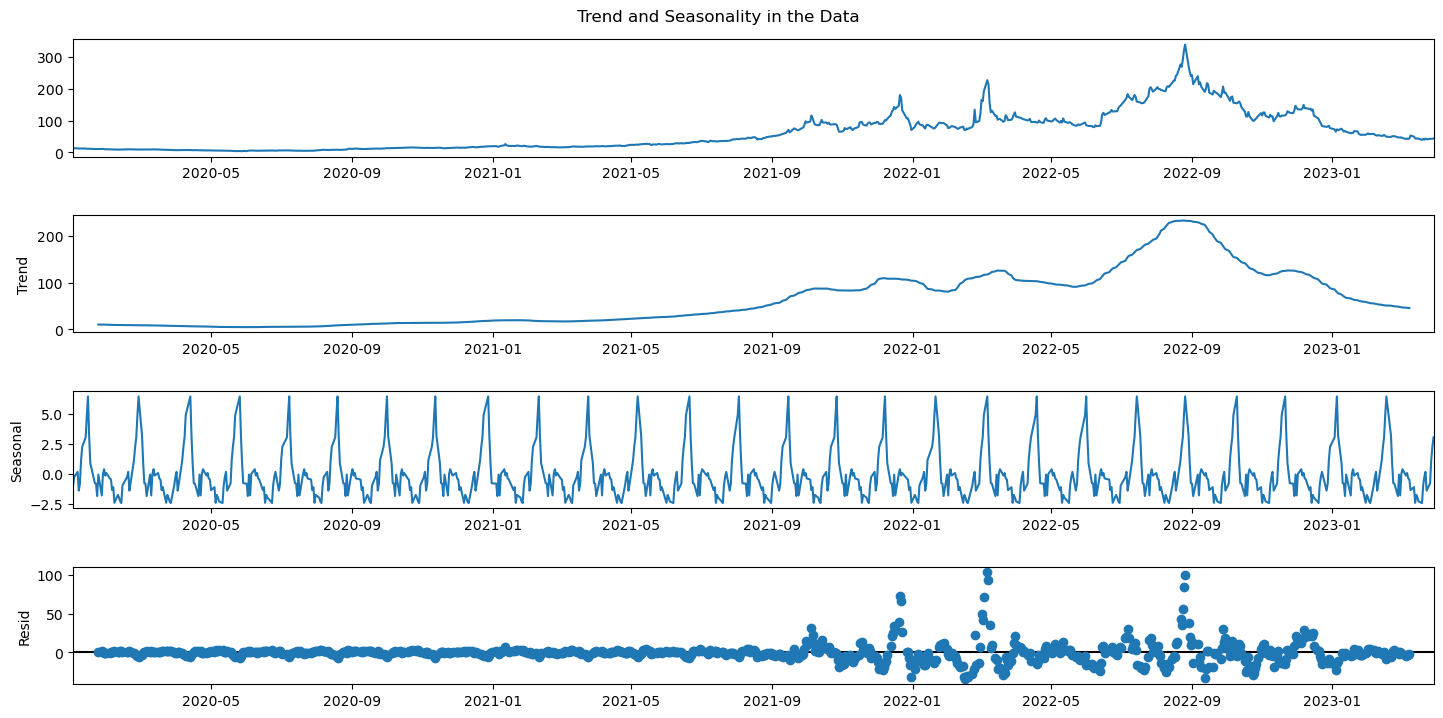

In [24]:
# Trends and Seasonality(Exploration plot)
trendNseasonality(dHs[['Close']],model='additive',period=30)

# 20. Relationship between fields
Now, we have to a limit have understood how our data is behaving. Let us explore more into the relation between the fields among themselves. In this connection we will explore
Pairplot: Plot pairwise relationships in a dataset.
Box and Whiskers plot: A box plot (or box-and-whisker plot) shows the distribution of quantitative data in a way that facilitates comparisons between variables or across levels of a categorical variable. The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the inter-quartile range.
Correlation Heatmap: Plot rectangular data as a color-encoded matrix.
and various other paired field scatterplots among the datafields we are studying.

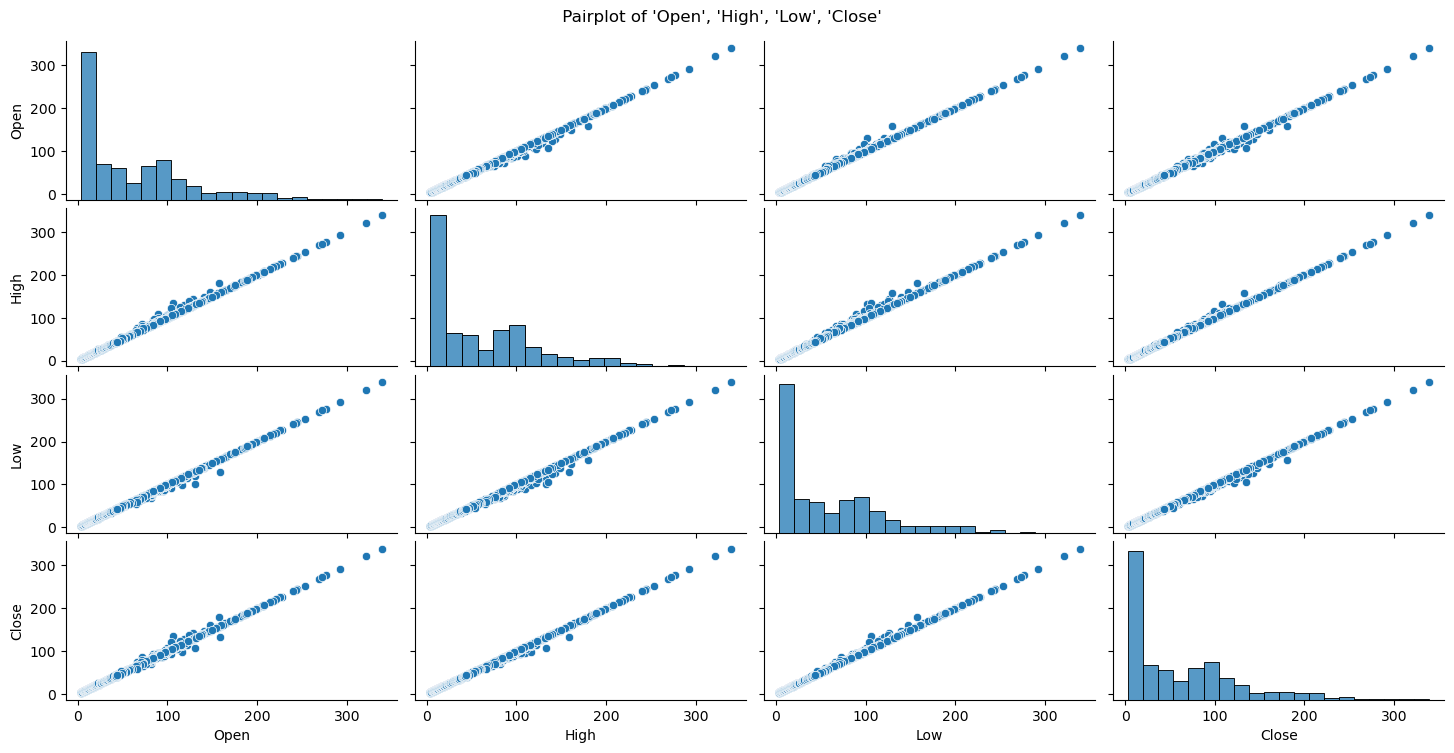

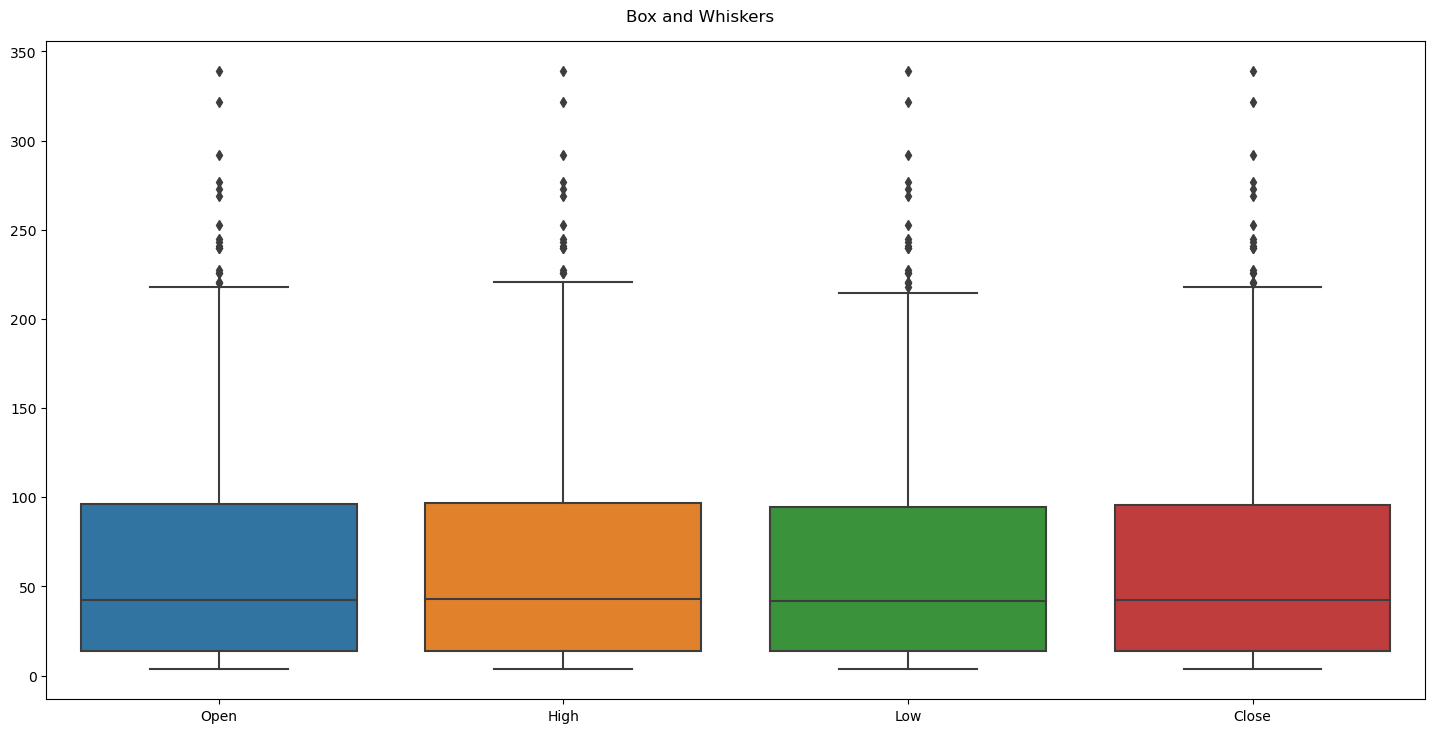

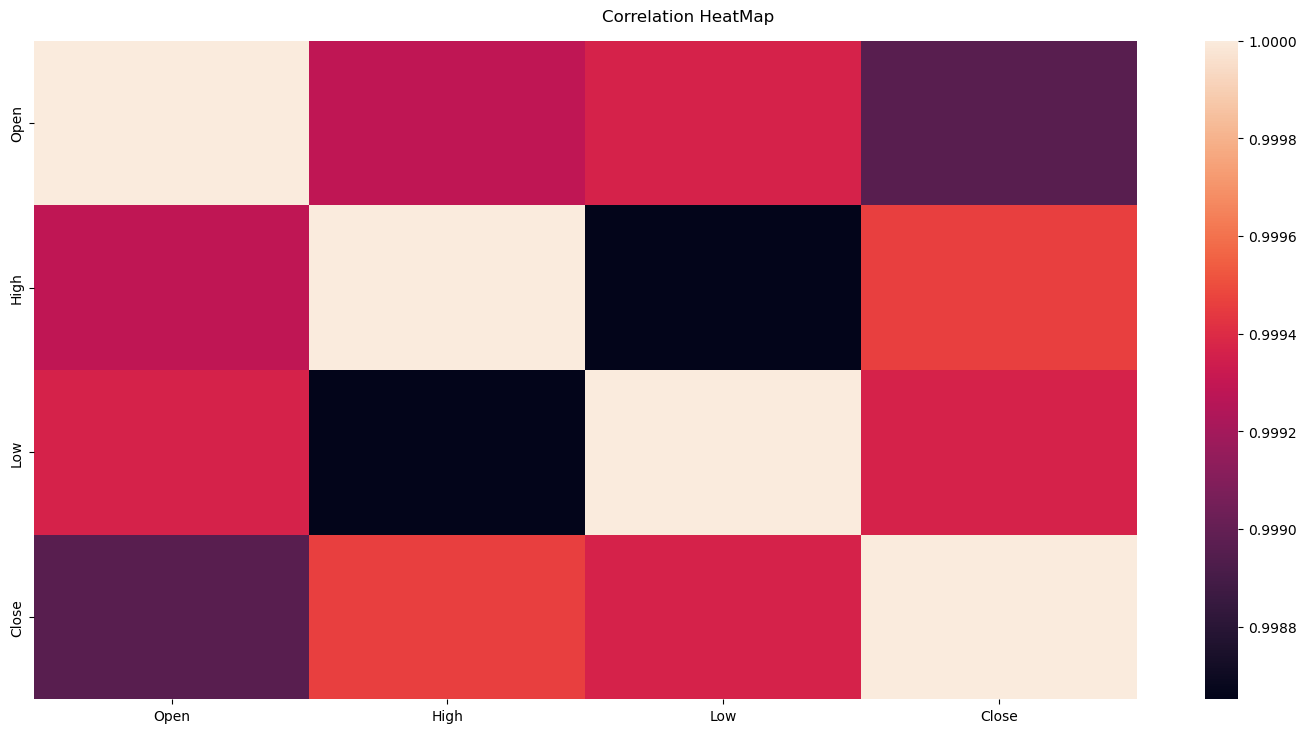

In [25]:
# Interfield relation plots
fullDataPlots(dHs[['Open','High','Low','Close']],title=" Pairplot of %s"%str(['Open','High','Low','Close'])[1:-1]) # pairplot 
fullDataPlots(dHs[['Open','High','Low','Close']],method=sns.boxplot,title='Box and Whiskers') # boxplot 
fullDataPlots(dHs[['Open','High','Low','Close']].corr(),method=sns.heatmap,title='Correlation HeatMap') # boxplot 

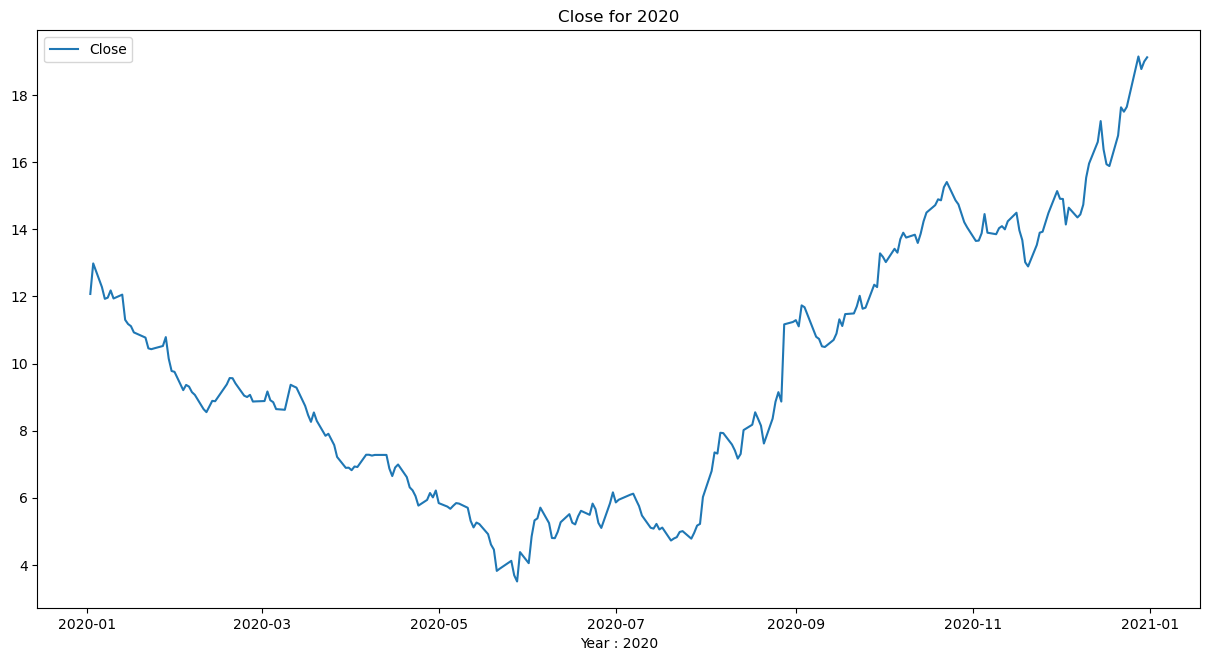

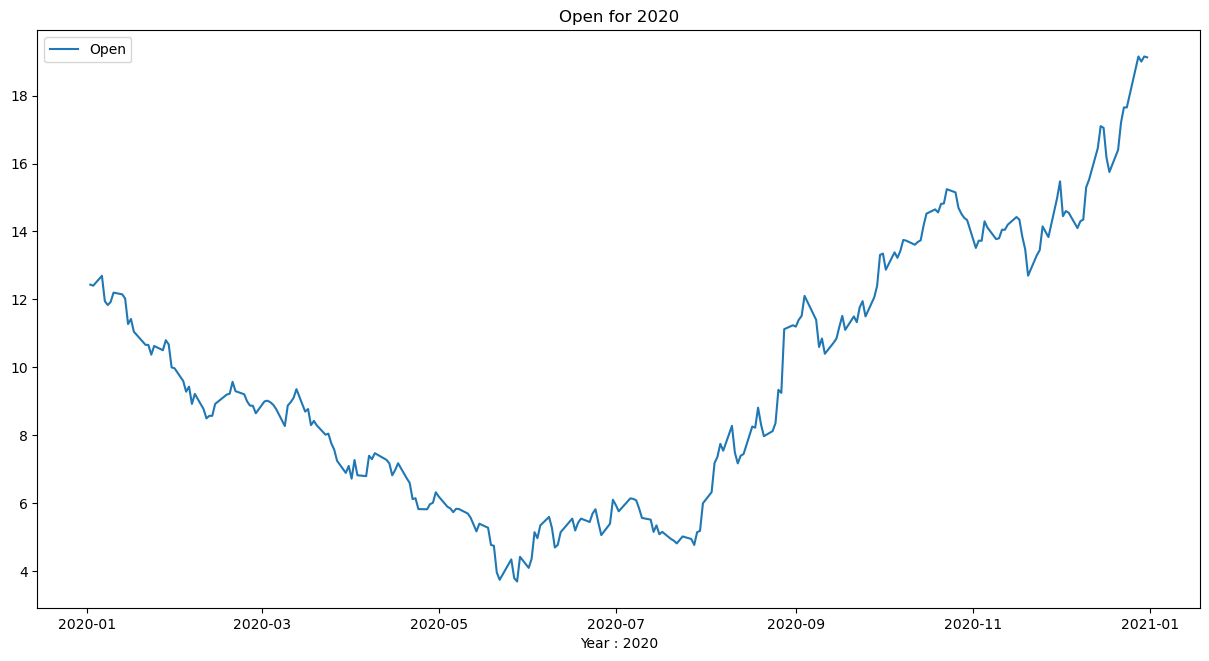

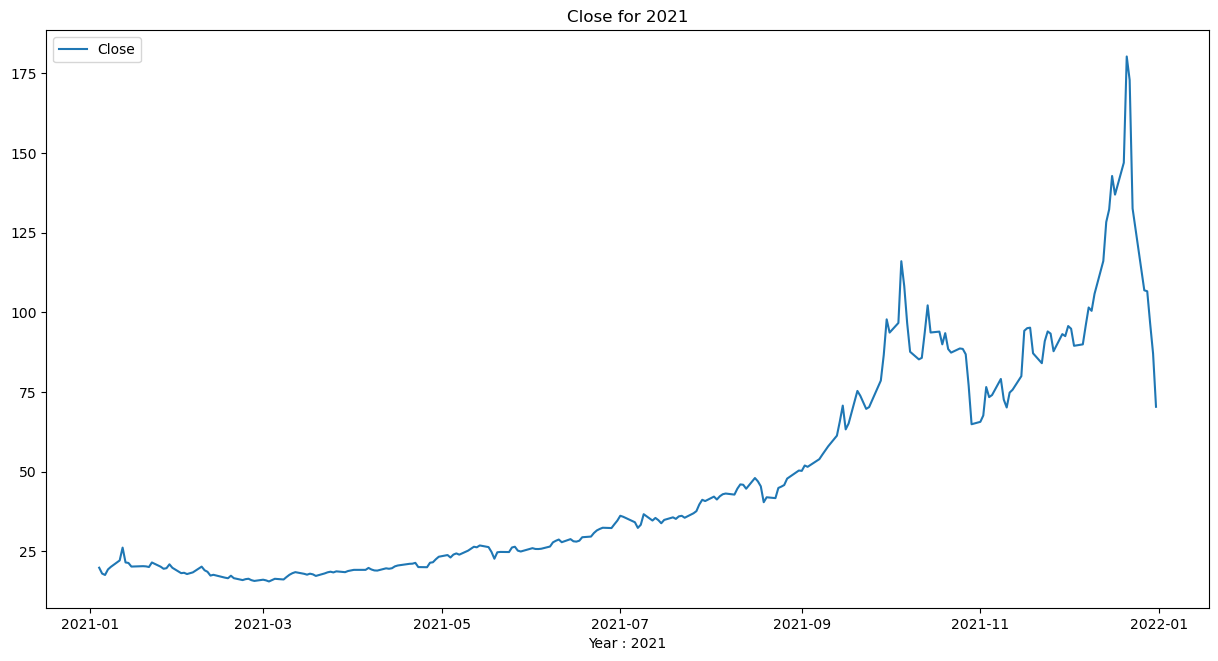

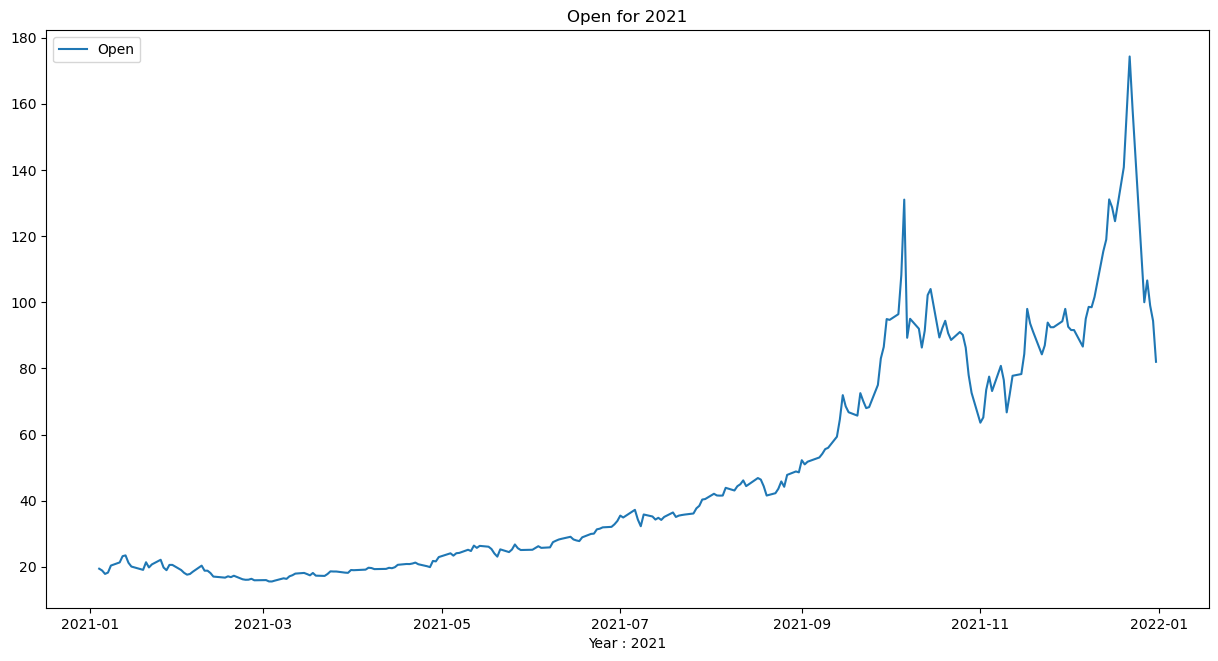

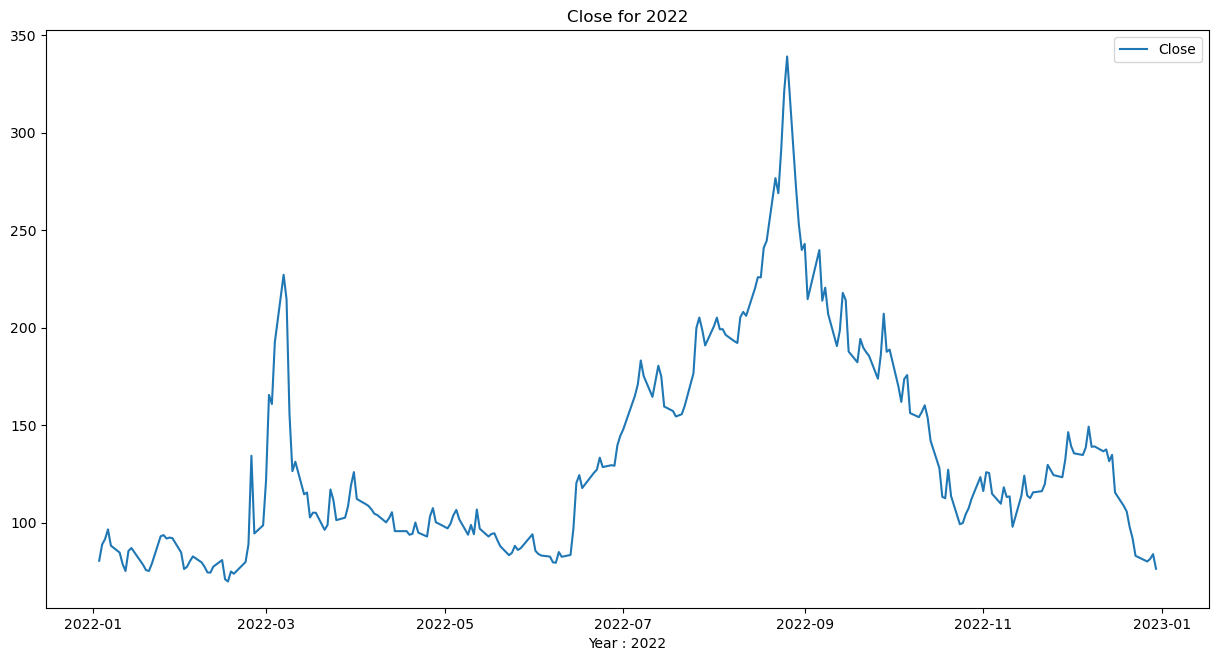

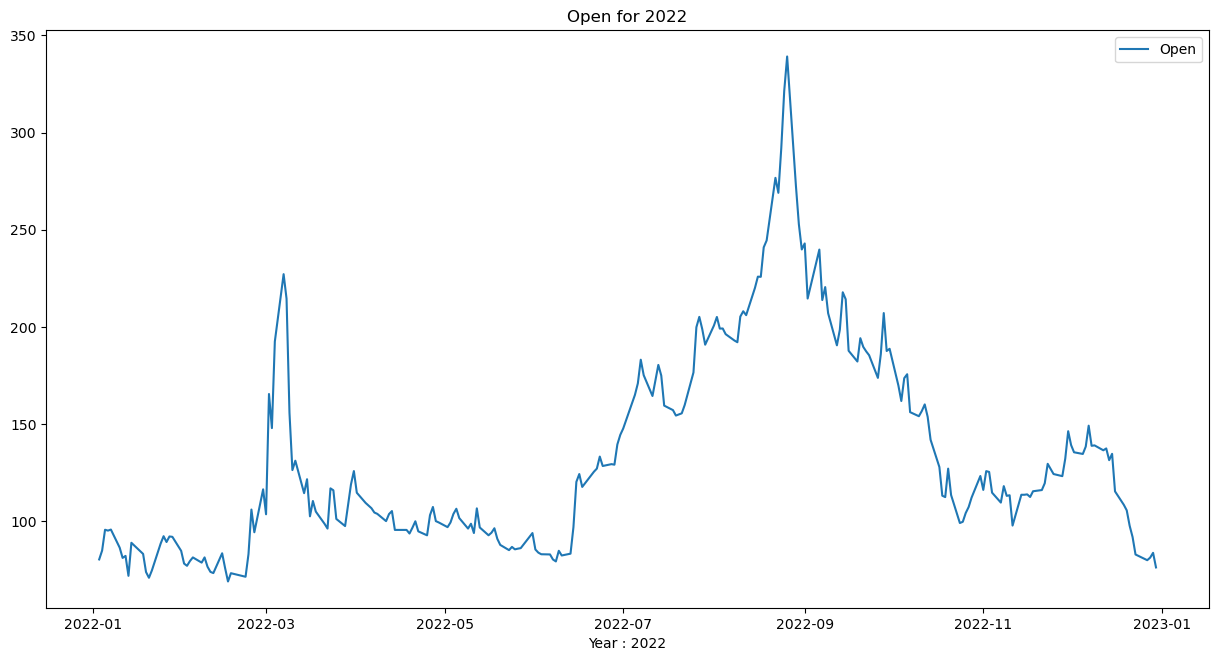

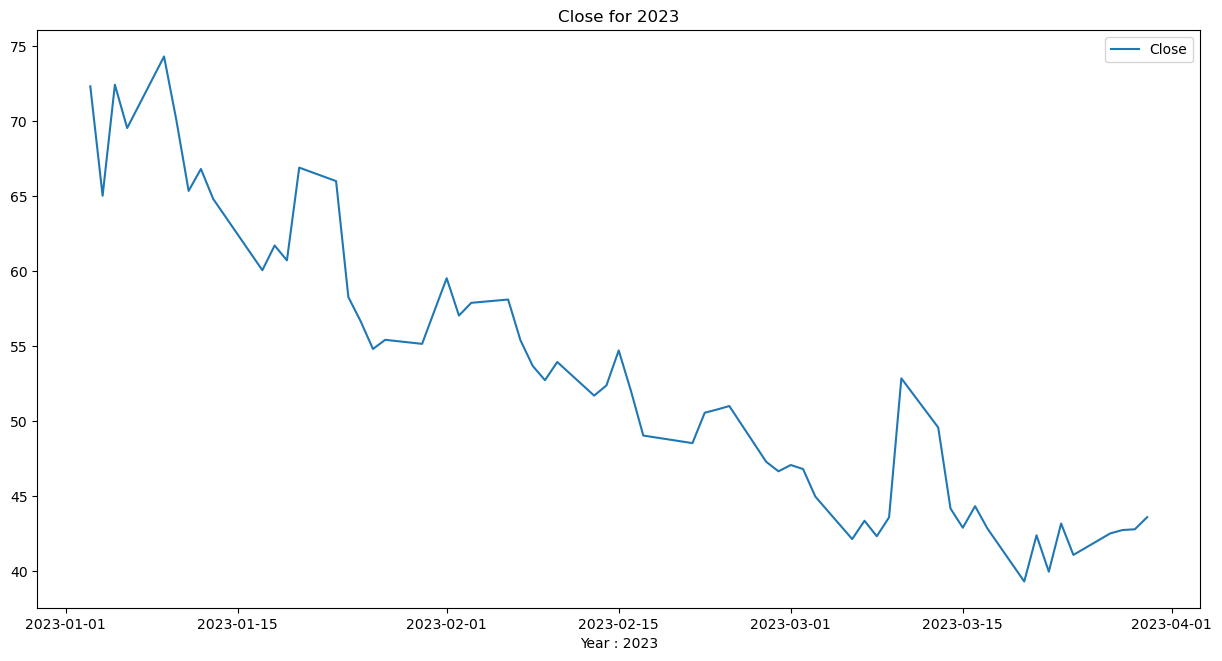

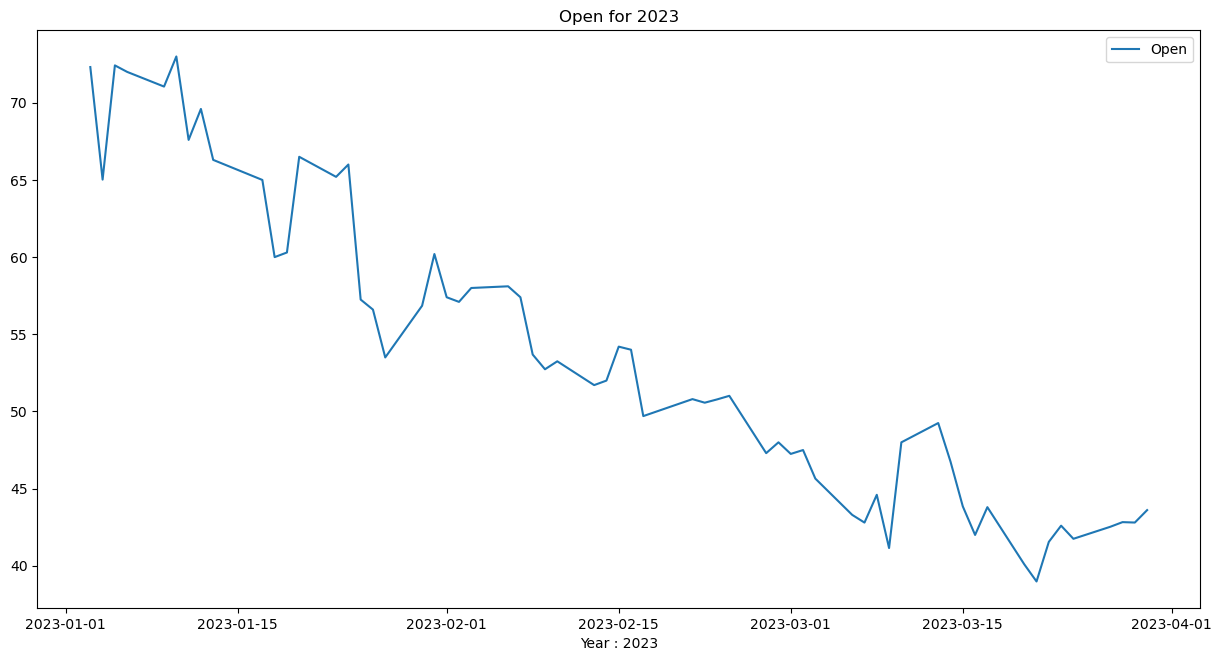

In [26]:
for year in sorted(set(dHs.index.year)):
    yearVariation(dHs[['Close']],year)
    yearVariation(dHs[['Open']],year)

<a id='@23'></a>
### 23. **Machine Learning and How it helps here (types and uses)**
---
From the begining we have been telling about models and machine learning algorithms.
The use and development of computer systems that are able to learn and adapt without following explicit instructions, by using algorithms and statistical models to analyse and draw inferences from patterns in data.

Machine learning is an application of artificial intelligence (AI) that provides systems the ability to automatically learn and improve from experience without being explicitly programmed. Machine learning focuses on the development of computer programs that can access data and use it to learn for themselves.

The process of learning begins with observations or data, such as examples, direct experience, or instruction, in order to look for patterns in data and make better decisions in the future based on the examples that we provide. The primary aim is to allow the computers learn automatically without human intervention or assistance and adjust actions accordingly.

But, using the classic algorithms of machine learning, text is considered as a sequence of keywords; instead, an approach based on semantic analysis mimics the human ability to understand the meaning of a text.


#### Some Machine Learning Methods
Machine learning algorithms are often categorized as supervised or unsupervised.

* **Supervised machine learning algorithms** can apply what has been learned in the past to new data using labeled examples to predict future events. Starting from the analysis of a known training dataset, the learning algorithm produces an inferred function to make predictions about the output values. The system is able to provide targets for any new input after sufficient training. The learning algorithm can also compare its output with the correct, intended output and find errors in order to modify the model accordingly.
* In contrast, **unsupervised machine learning algorithms** are used when the information used to train is neither classified nor labeled. Unsupervised learning studies how systems can infer a function to describe a hidden structure from unlabeled data. The system doesn’t figure out the right output, but it explores the data and can draw inferences from datasets to describe hidden structures from unlabeled data.
* **Semi-supervised machine learning algorithms** fall somewhere in between supervised and unsupervised learning, since they use both labeled and unlabeled data for training – typically a small amount of labeled data and a large amount of unlabeled data. The systems that use this method are able to considerably improve learning accuracy. Usually, semi-supervised learning is chosen when the acquired labeled data requires skilled and relevant resources in order to train it / learn from it. Otherwise, acquiring unlabeled data generally doesn’t require additional resources.
* **Reinforcement machine learning algorithms** is a learning method that interacts with its environment by producing actions and discovers errors or rewards. Trial and error search and delayed reward are the most relevant characteristics of reinforcement learning. This method allows machines and software agents to automatically determine the ideal behavior within a specific context in order to maximize its performance. Simple reward feedback is required for the agent to learn which action is best; this is known as the reinforcement signal.
Machine learning enables analysis of massive quantities of data. While it generally delivers faster, more accurate results in order to identify profitable opportunities or dangerous risks, it may also require additional time and resources to train it properly. Combining machine learning with AI and cognitive technologies can make it even more effective in processing large volumes of information.

<br>
#### Why we are using Machine Learning here
It is a well-known fact that Machine Learning is a powerful technique in imagining, speech and natural language processing for a huge explicated dataset available. On the other hand,
* Problems based on time series do not have usually interpreted datasets, even as data is collected from various sources so exhibit substantial variations in terms of features, properties, attributes, temporal scales, and dimensionality.
* Time series analysis requires such sorting algorithms that can allow it to learn time-dependent patterns across multiples models different from images and speech.
* Various machine learning tools such as classification, clustering, forecasting, and anomaly detection depend upon real-world business applications. 
Among various defined applications, discussing here Time series forecasting, it is an important area of machine learning because there are multiple problems involving time components for making predictions. There are multiple models and methods used as approaches for time series forecasting, let’s understand them more clearly;

Here in connection to all the work mention must be made of Sklearn library which is being exclusively used for this case study.

Scikit-learn (formerly scikits.learn and also known as sklearn) is a free software machine learning library for the Python programming language. It features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN, and is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy.

The scikit-learn project started as scikits.learn, a Google Summer of Code project by David Cournapeau. Its name stems from the notion that it is a "SciKit" (SciPy Toolkit), a separately-developed and distributed third-party extension to SciPy. The original codebase was later rewritten by other developers. In 2010 Fabian Pedregosa, Gael Varoquaux, Alexandre Gramfort and Vincent Michel, all from the French Institute for Research in Computer Science and Automation in Rocquencourt, France, took leadership of the project and made the first public release on February the 1st 2010. Of the various scikits, scikit-learn as well as scikit-image were described as "well-maintained and popular" in November 2012. Scikit-learn is one of the most popular machine learning libraries on GitHub.

**Now lets import the machine learning models from sklearn for our work**

In [27]:
# model class imports 
from sklearn.linear_model import LinearRegression as LinReg  #Linear Regression
from sklearn.ensemble import RandomForestRegressor as RnForReg  #Random Forest Regression
from sklearn.svm import SVR #Support Vector Machine Regression
from sklearn.linear_model import BayesianRidge as BayesR   #Bayesian Ridge Regression

<a id='@24'></a>
### 24. **Why Regression? How the Regression Works ?**
---
A keen observer might have already noticed that we have brought only regression models into our field. 
Regression analysis is an incredibly powerful machine learning tool used for analyzing data. 
#### What Is Regression in Machine Learning?
Regression analysis is a way of predicting future happenings between a dependent (target) and one or more independent variables (also known as a predictor). For example, it can be used to predict the relationship between reckless driving and the total number of road accidents caused by a driver, or, to use a business example, the effect on sales and spending a certain amount of money on advertising.

Regression is one of the most common models of machine learning. It differs from classification models because it estimates a numerical value, whereas classification models identify which category an observation belongs to. _The main uses of regression analysis are forecasting, time series modeling and finding the cause and effect relationship between variables_. This also proves our point in usage of these algorithms.
#### Why Is It Important?
Regression has a wide range of real-life applications. It is essential for any machine learning problem that involves continuous numbers – this includes, but is not limited to, a host of examples, including:

*  Financial forecasting (like house price estimates, or stock prices)
*  Sales and promotions forecasting
*  Testing automobiles
*  Weather analysis and prediction
*  Time series forecasting

As well as telling us whether a significant relationship exists between two or more variables, regression analysis can give specific details about that relationship. Specifically, it can estimate the strength of impact that multiple variables will have on a dependent variable. If we change the value of one variable (price, say), regression analysis should tell us what effect that will have on the dependent variable (sales).

#### Terminologies used in Regression Analysis
* **Outliers**
    Suppose there is an observation in the dataset that has a very high or very low value as compared to the other observations in the data, i.e. it does not belong to the population, such an observation is called an outlier. In simple words, it is an extreme value. An outlier is a problem because many times it hampers the results we get.
* **Multicollinearity**
    When the independent variables are highly correlated to each other, then the variables are said to be multicollinear. Many types of regression techniques assume multicollinearity should not be present in the dataset. It is because it causes problems in ranking variables based on its importance, or it makes the job difficult in selecting the most important independent variable.
* **Heteroscedasticity**
    When the variation between the target variable and the independent variable is not constant, it is called heteroscedasticity. Example-As one’s income increases, the variability of food consumption will increase. A poorer person will spend a rather constant amount by always eating inexpensive food; a wealthier person may occasionally buy inexpensive food and at other times, eat expensive meals. Those with higher incomes display a greater variability of food consumption.
* **Underfit and Overfit**
    When we use unnecessary explanatory variables, it might lead to overfitting. Overfitting means that our algorithm works well on the training set but is unable to perform better on the test sets. It is also known as a problem of high variance.
    When our algorithm works so poorly that it is unable to fit even a training set well, then it is said to underfit the data. It is also known as a problem of high bias.



<a id='@25'></a>
### 25. **Definition of Models (A brief idea of their _modus operandi_)**
---
#### Linear regression
 &nbsp; &nbsp; &nbsp; &nbsp;One of the most basic types of regression in machine learning, linear regression comprises a predictor variable and a dependent variable related to each other in a linear fashion. Linear regression involves the use of a best fit line. We should use linear regression when our variables are related linearly. For example, if we are forecasting the effect of increased advertising spend on sales. However, this analysis is susceptible to outliers, so it should not be used to analyze big data sets.
#### Bayesian Ridge
 &nbsp; &nbsp; &nbsp; &nbsp;In the Bayesian viewpoint, we formulate linear regression using probability distributions rather than point estimates. The response, y, is not estimated as a single value, but is assumed to be drawn from a probability distribution. The model for Bayesian Linear Regression with the response sampled from a normal distribution is:
 
 $y $~$ N(\beta^T X, \sigma^2 I)$

The aim of Bayesian Linear Regression is not to find the single “best” value of the model parameters, but rather to determine the posterior distribution for the model parameters. Not only is the response generated from a probability distribution, but the model parameters are assumed to come from a distribution as well. 
#### Random Forest
A random forest is a machine learning technique that’s used to solve regression and classification problems. It utilizes ensemble learning, which is a technique that combines many classifiers to provide solutions to complex problems. A random forest algorithm consists of many decision trees. The ‘forest’ generated by the random forest algorithm is trained through bagging or bootstrap aggregating. Bagging is an ensemble meta-algorithm that improves the accuracy of machine learning algorithms.

##### Features of a Random Forest Algorithm
* It’s more accurate than the decision tree algorithm.
* It provides an effective way of handling missing data.
* It can produce a reasonable prediction without hyper-parameter tuning.
* It solves the issue of overfitting in decision trees.
* In every random forest tree, a subset of features is selected randomly at the node’s splitting point.

##### How random forest algorithm works
###### Understanding decision trees
Decision trees are the building blocks of a random forest algorithm. A decision tree is a decision support technique that forms a tree-like structure. An overview of decision trees will help us understand how random forest algorithms work.
A decision tree consists of three components: decision nodes, leaf nodes, and a root node. A decision tree algorithm divides a training dataset into branches, which further segregate into other branches. This sequence continues until a leaf node is attained. The leaf node cannot be segregated further.
###### Applying decision trees in random forest
The main difference between the decision tree algorithm and the random forest algorithm is that establishing root nodes and segregating nodes is done randomly in the latter. The random forest employs the bagging method to generate the required prediction.
Bagging involves using different samples of data (training data) rather than just one sample. A training dataset comprises observations and features that are used for making predictions. The decision trees produce different outputs, depending on the training data fed to the random forest algorithm. These outputs will be ranked, and the highest will be selected as the final output.
#### Support Vector Machines
"Support Vector Machine" (SVM) is a supervised machine learning algorithm that can be used for both classification or regression challenges. However,  it is mostly used in classification problems. In the SVM algorithm, we plot each data item as a point in n-dimensional space (where n is a number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiates the two classes very well.

**_Let us now generate the model dictionaries_**

In [28]:
from copy import deepcopy
#Model Creation and study
models_name={'LR':"Linear Regression",
             'RF':"Random Forest",
             'SV':"Support Vector",
             'BR':"Bayesian Ridge"};
models_mods_norm={'LR':ModelParameters(model=LinReg()),
                  'RF':ModelParameters(model=RnForReg()),
                  'SV':ModelParameters(model=SVR()),
                  'BR':ModelParameters(model=BayesR())};
models_mods_CVKF=deepcopy(models_mods_norm);

<a id='@26'></a>
### 26. **Training models(Stock Method - as is, fresh out of the box)**
---
Let us train the models as they are without any preset defined by us. Any preset values if any applied is solely as is shipped by sklearn library.

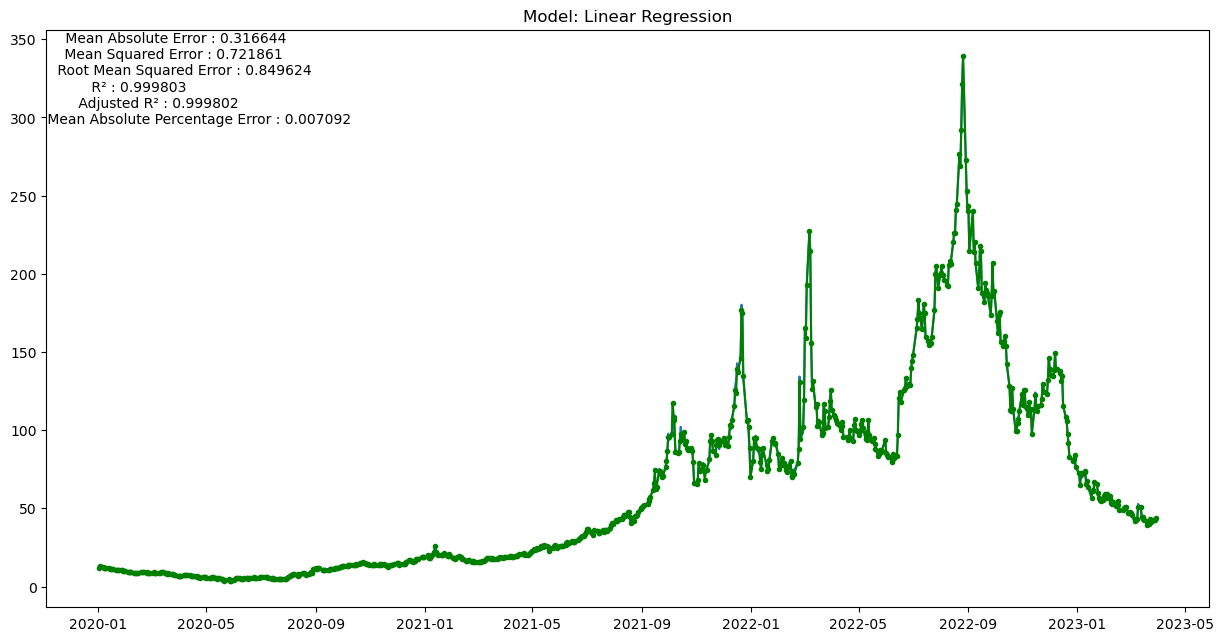

______________________________________________________________________
 Regression Metrics Report 
                Mean Absolute Error:        0.286228
                 Mean Squared Error:        0.515534
            Root Mean Squared Error:        0.718007
             Mean Squared Log Error:        0.000126
              Median Absolute Error:        0.080993
                                R² :        0.999842
                       Adjusted R² :        0.999840
              Mean Poisson Deviance:        0.006836
                Mean Gamma Deviance:        0.000138
                          Max Error:        5.269339
                 Explained Variance:        0.999843
     Mean Absolute Percentage Error:        0.006773
______________________________________________________________________
 Percentiles 
              5:       -0.647303
             25:       -0.047261
             50:        0.008401
             75:        0.097532
             95:        0.479988


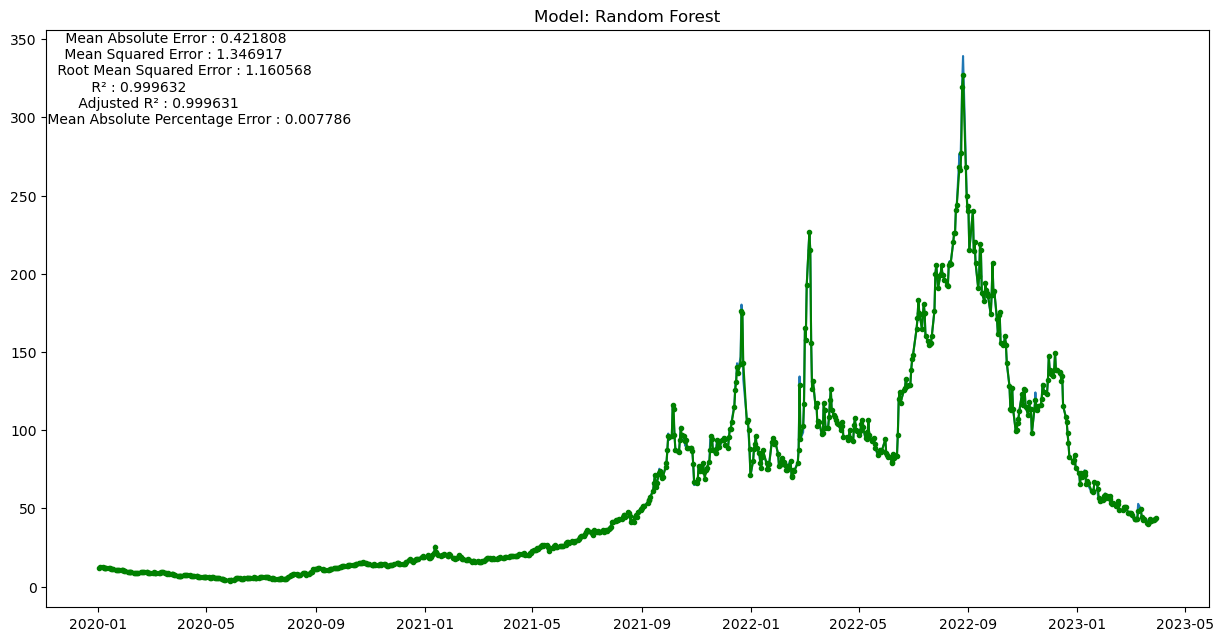

______________________________________________________________________
 Regression Metrics Report 
                Mean Absolute Error:        0.655587
                 Mean Squared Error:        2.356498
            Root Mean Squared Error:        1.535089
             Mean Squared Log Error:        0.000363
              Median Absolute Error:        0.242401
                                R² :        0.999279
                       Adjusted R² :        0.999270
              Mean Poisson Deviance:        0.020172
                Mean Gamma Deviance:        0.000409
                          Max Error:       15.241493
                 Explained Variance:        0.999283
     Mean Absolute Percentage Error:        0.013144
______________________________________________________________________
 Percentiles 
              5:       -1.313485
             25:       -0.248693
             50:       -0.018600
             75:        0.240600
             95:        1.358594


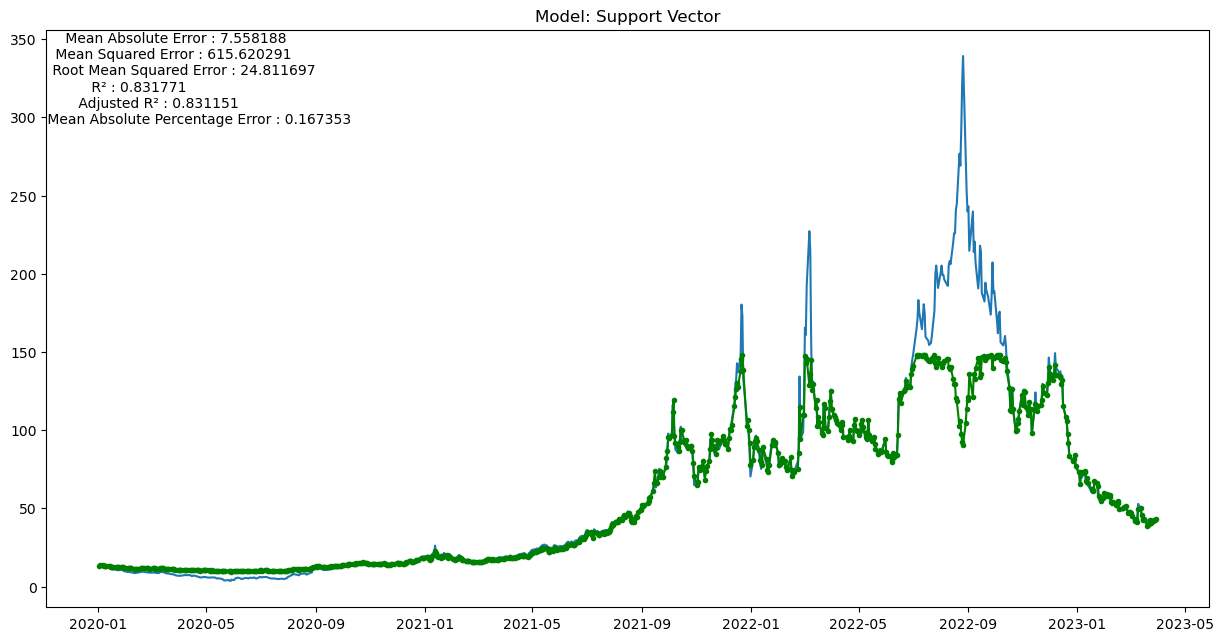

______________________________________________________________________
 Regression Metrics Report 
                Mean Absolute Error:        6.055355
                 Mean Squared Error:      473.576560
            Root Mean Squared Error:       21.761814
             Mean Squared Log Error:        0.050083
              Median Absolute Error:        1.497857
                                R² :        0.855179
                       Adjusted R² :        0.853383
              Mean Poisson Deviance:        3.384627
                Mean Gamma Deviance:        0.057731
                          Max Error:      194.424264
                 Explained Variance:        0.860418
     Mean Absolute Percentage Error:        0.148815
______________________________________________________________________
 Percentiles 
              5:       -4.612997
             25:       -1.577500
             50:        0.010050
             75:        1.448272
             95:       21.575904


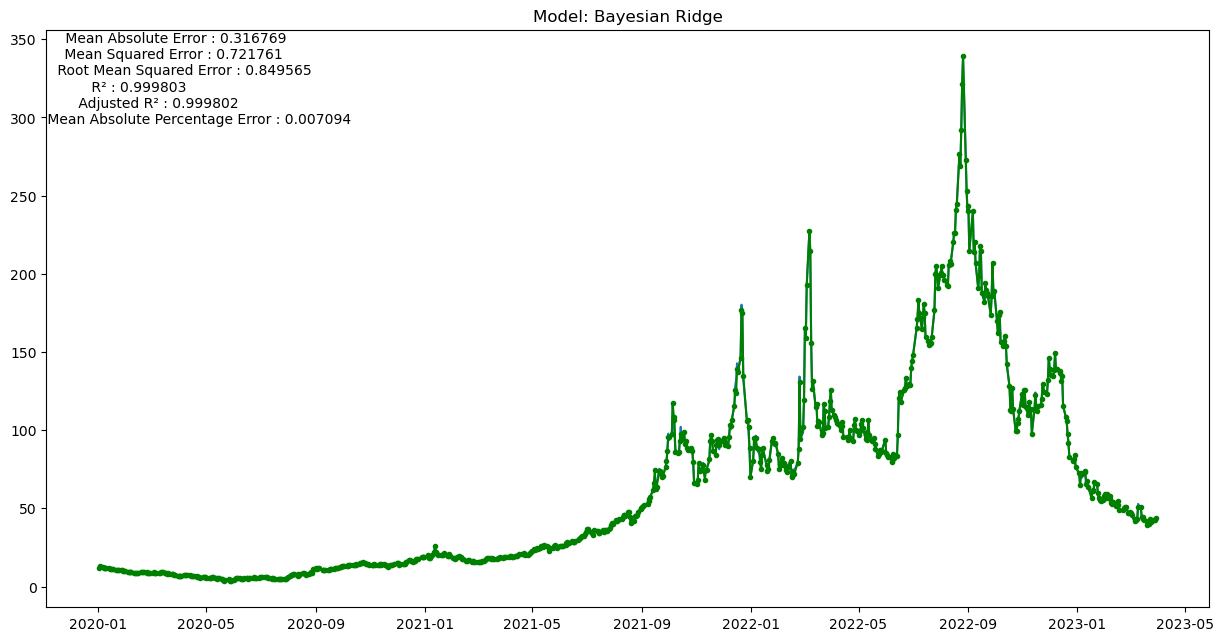

______________________________________________________________________
 Regression Metrics Report 
                Mean Absolute Error:        0.286261
                 Mean Squared Error:        0.515190
            Root Mean Squared Error:        0.717767
             Mean Squared Log Error:        0.000126
              Median Absolute Error:        0.080898
                                R² :        0.999842
                       Adjusted R² :        0.999841
              Mean Poisson Deviance:        0.006831
                Mean Gamma Deviance:        0.000138
                          Max Error:        5.267764
                 Explained Variance:        0.999843
     Mean Absolute Percentage Error:        0.006774
______________________________________________________________________
 Percentiles 
              5:       -0.647429
             25:       -0.047539
             50:        0.008391
             75:        0.097176
             95:        0.480816


In [29]:
# Train and Test (Stock process)
for mod_key in models_mods_norm:
    models_mods_norm[mod_key].pushData(data=dHs,predicts=['Open','High','Low'],infers="Close")
    models_mods_norm[mod_key].normal_split()
    models_mods_norm[mod_key].train()
    models_mods_norm[mod_key].plotMetrics(data=dHs,title="Model: "+models_name[mod_key])
    models_mods_norm[mod_key].regression_report()

<a id='@27'></a>
### 27. **What is Cross-Validation ? Why we use it ?**
---
Cross-validation is a statistical method used to estimate the skill of machine learning models.
It is commonly used in applied machine learning to compare and select a model for a given predictive modeling problem because it is easy to understand, easy to implement, and results in skill estimates that generally have a lower bias than other methods.
 Cross validation is a model evaluation method that is better than residuals. The problem with residual evaluations is that they do not give an indication of how well the learner will do when it is asked to make new predictions for data it has not already seen. One way to overcome this problem is to not use the entire data set when training a learner. Some of the data is removed before training begins. Then when training is done, the data that was removed can be used to test the performance of the learned model on _"new"_ data. This is the basic idea for a whole class of model evaluation methods called cross validation.

The holdout method is the simplest kind of cross validation. The data set is separated into two sets, called the training set and the testing set. The function approximator fits a function using the training set only. Then the function approximator is asked to predict the output values for the data in the testing set (it has never seen these output values before). The errors it makes are accumulated as before to give the mean absolute test set error, which is used to evaluate the model. The advantage of this method is that it is usually preferable to the residual method and takes no longer to compute. However, its evaluation can have a high variance. The evaluation may depend heavily on which data points end up in the training set and which end up in the test set, and thus the evaluation may be significantly different depending on how the division is made.

K-fold cross validation is one way to improve over the holdout method. The data set is divided into k subsets, and the holdout method is repeated k times. Each time, one of the k subsets is used as the test set and the other k-1 subsets are put together to form a training set. Then the average error across all k trials is computed. The advantage of this method is that it matters less how the data gets divided. Every data point gets to be in a test set exactly once, and gets to be in a training set k-1 times. The variance of the resulting estimate is reduced as k is increased. The disadvantage of this method is that the training algorithm has to be rerun from scratch k times, which means it takes k times as much computation to make an evaluation. A variant of this method is to randomly divide the data into a test and training set k different times. The advantage of doing this is that you can independently choose how large each test set is and how many trials you average over.

#### Variations on Data splits and Cross-Validation
There are a number of variations on the k-fold cross validation procedure.
* Train/Test Split: Taken to one extreme, k may be set to 2 (not 1) such that a single train/test split is created to evaluate the model. The one we accomplished in the [previous section](#@26)
* LOOCV: Taken to another extreme, k may be set to the total number of observations in the dataset such that each observation is given a chance to be the held out of the dataset. This is called leave-one-out cross-validation, or LOOCV for short.
* Stratified: The splitting of data into folds may be governed by criteria such as ensuring that each fold has the same proportion of observations with a given categorical value, such as the class outcome value. This is called stratified cross-validation.
* Repeated: This is where the k-fold cross-validation procedure is repeated n times, where importantly, the data sample is shuffled prior to each repetition, which results in a different split of the sample.
* Nested: This is where k-fold cross-validation is performed within each fold of cross-validation, often to perform hyperparameter tuning during model evaluation. This is called nested cross-validation or double cross-validation
#### k-Fold Cross-Validation (detailed)
Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.
The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.
It is a popular method because it is simple to understand and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split.

The general procedure is as follows:

1. Shuffle the dataset randomly.
2. Split the dataset into k groups
3. For each unique group:
  1. Take the group as a hold out or test data set
  2. Take the remaining groups as a training data set
  3. Fit a model on the training set and evaluate it on the test set
  4. Retain the evaluation score and discard the model
4. Summarize the skill of the model using the sample of model evaluation scores
![Cross_val_IMG](https://miro.medium.com/max/2000/1*fW_qNKmvmg8duWoQnp_PoQ.png)

**_Let us evaluate the set of models with data splits made using K-Fold Cross Validation_**

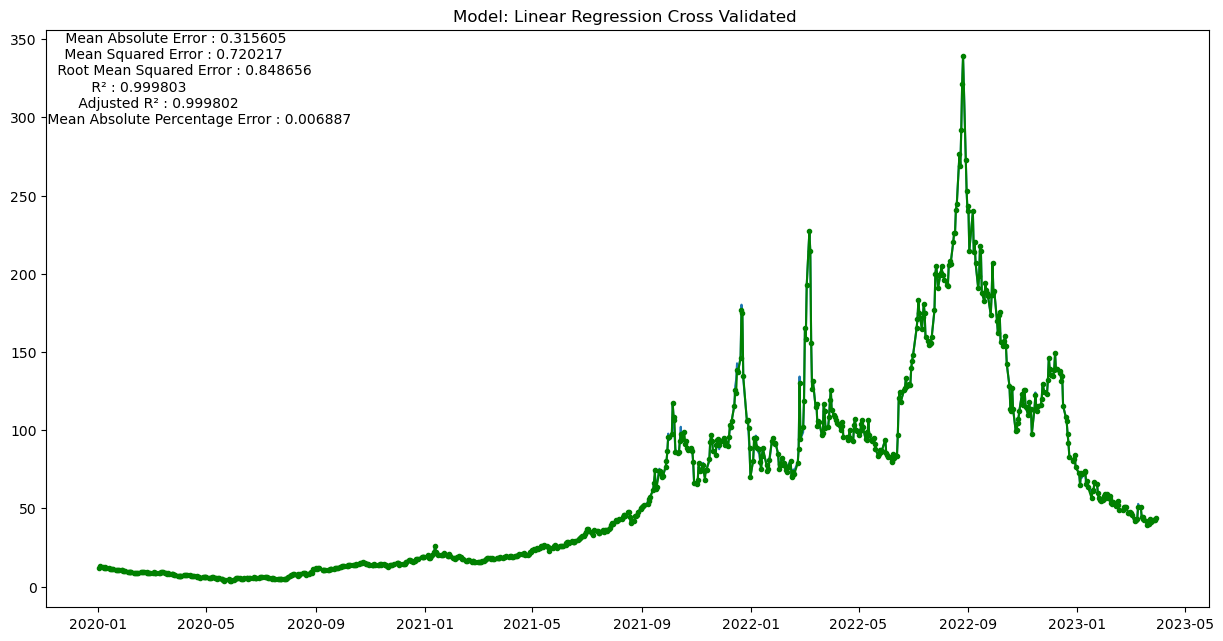

______________________________________________________________________
 Regression Metrics Report 
                Mean Absolute Error:        0.194514
                 Mean Squared Error:        0.291012
            Root Mean Squared Error:        0.539455
             Mean Squared Log Error:        0.000075
              Median Absolute Error:        0.030114
                                R² :        0.999939
                       Adjusted R² :        0.999938
              Mean Poisson Deviance:        0.004673
                Mean Gamma Deviance:        0.000078
                          Max Error:        3.730768
                 Explained Variance:        0.999939
     Mean Absolute Percentage Error:        0.003174
______________________________________________________________________
 Percentiles 
              5:       -0.485795
             25:       -0.042830
             50:       -0.013930
             75:        0.000157
             95:        0.375633


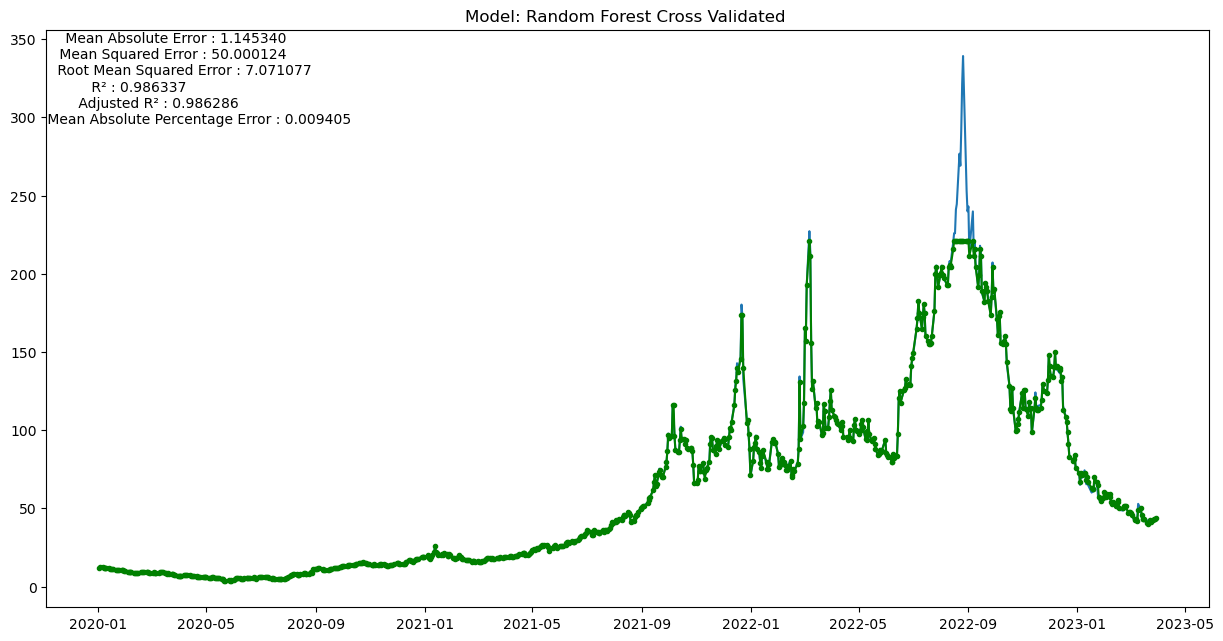

______________________________________________________________________
 Regression Metrics Report 
                Mean Absolute Error:        4.621943
                 Mean Squared Error:      248.589515
            Root Mean Squared Error:       15.766722
             Mean Squared Log Error:        0.003938
              Median Absolute Error:        0.816886
                                R² :        0.947660
                       Adjusted R² :        0.946672
              Mean Poisson Deviance:        1.017762
                Mean Gamma Deviance:        0.004391
                          Max Error:      117.980851
                 Explained Variance:        0.950228
     Mean Absolute Percentage Error:        0.024507
______________________________________________________________________
 Percentiles 
              5:       -2.004225
             25:       -0.823430
             50:       -0.145828
             75:        0.792962
             95:       21.588835


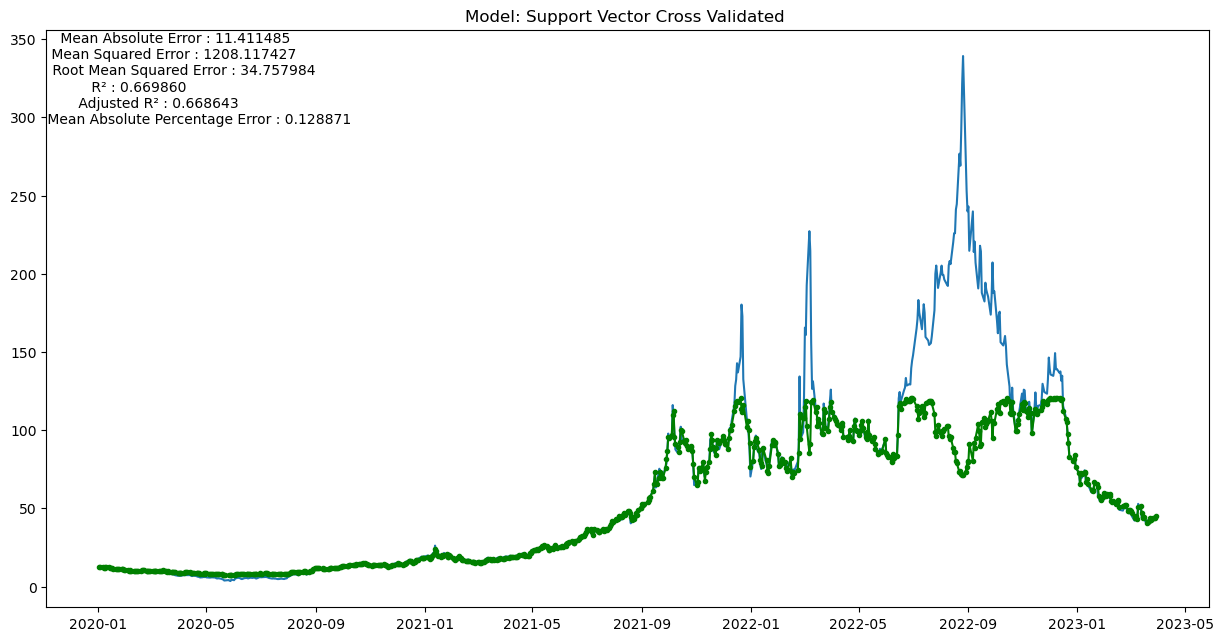

______________________________________________________________________
 Regression Metrics Report 
                Mean Absolute Error:       36.702407
                 Mean Squared Error:     4831.197075
            Root Mean Squared Error:       69.506813
             Mean Squared Log Error:        0.213018
              Median Absolute Error:        2.688681
                                R² :       -0.017199
                       Adjusted R² :       -0.036392
              Mean Poisson Deviance:       37.821451
                Mean Gamma Deviance:        0.319752
                          Max Error:      267.675460
                 Explained Variance:        0.251335
     Mean Absolute Percentage Error:        0.180284
______________________________________________________________________
 Percentiles 
              5:       -2.301520
             25:       -0.884486
             50:        2.423998
             75:       59.236544
             95:      163.328662


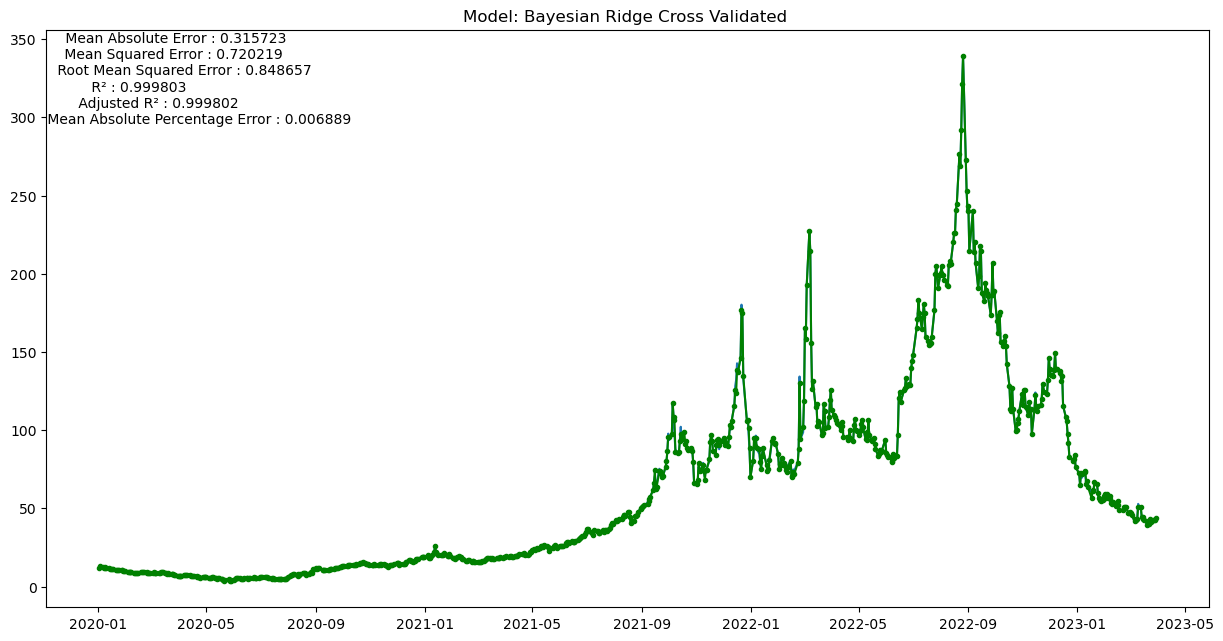

______________________________________________________________________
 Regression Metrics Report 
                Mean Absolute Error:        0.194656
                 Mean Squared Error:        0.291007
            Root Mean Squared Error:        0.539451
             Mean Squared Log Error:        0.000075
              Median Absolute Error:        0.030129
                                R² :        0.999939
                       Adjusted R² :        0.999938
              Mean Poisson Deviance:        0.004672
                Mean Gamma Deviance:        0.000078
                          Max Error:        3.724794
                 Explained Variance:        0.999939
     Mean Absolute Percentage Error:        0.003176
______________________________________________________________________
 Percentiles 
              5:       -0.487415
             25:       -0.042849
             50:       -0.013941
             75:        0.000151
             95:        0.377215


In [30]:
# Model training with K-Fold Cross Validation Splits
for mod_key in models_mods_CVKF:
    models_mods_CVKF[mod_key].pushData(data=dHs,predicts=['Open','High','Low'],infers="Close")
    models_mods_CVKF[mod_key].crossval_KF_split(n_splits=5,random_state=None,shuffle=False)
    models_mods_CVKF[mod_key].train()
    models_mods_CVKF[mod_key].plotMetrics(data=dHs,title="Model: "+models_name[mod_key]+" Cross Validated ")
    models_mods_CVKF[mod_key].regression_report()

<a id='@28'></a>
### 28. **How Cross-Validation improved our models ?**
---
Let's evaluate the improvemnts we made from training with data splits of two methods 
1. [General Split (70% train - 30% test)](#@26)
2. [Cross Validation Split(K - Fold at $K=5$)](#@27)

In [31]:
"""def improvement(oldVAL,newVAL,title_text=''):
            Calculate improvement of a value over its old self 
            ******************
            Variables 
           -------------------
           oldVAL : old value of the variable 
           newVAL : new value of the variable 
           ____________________
           prints improvement percentage 
           returns improvement in percentage (float) 
           imprv=100*(newVAL-oldVAL)/oldVAL
           print(title_text)
           print(' Improved by {:0.3f}%'.format(imprv))
           return imprv 
"""
    
for mod_key in models_name:
    print('\n__________________________________________________________________\n')
    improvement(models_mods_norm[mod_key].accuracy(),models_mods_CVKF[mod_key].accuracy(),models_name[mod_key])
    print("           Base Accuracy  : ",models_mods_norm[mod_key].accuracy())
    print(" Cross Validated Accuracy : ",models_mods_CVKF[mod_key].accuracy())


__________________________________________________________________

Linear Regression
 Improved by 0.362%
           Base Accuracy  :  99.32271143537098
 Cross Validated Accuracy :  99.68262119124071

__________________________________________________________________

Random Forest
 Improved by -1.151%
           Base Accuracy  :  98.68564760171864
 Cross Validated Accuracy :  97.54931056968233

__________________________________________________________________

Support Vector
 Improved by -3.697%
           Base Accuracy  :  85.11850978384804
 Cross Validated Accuracy :  81.97158866138835

__________________________________________________________________

Bayesian Ridge
 Improved by 0.362%
           Base Accuracy  :  99.32259687374373
 Cross Validated Accuracy :  99.6823887260662


while we are at this let us also check the residuals


__________________________________________________________________

Linear Regression


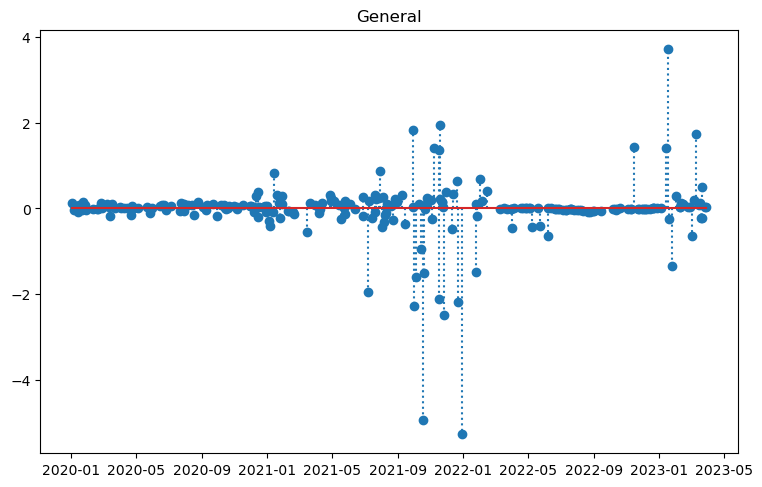

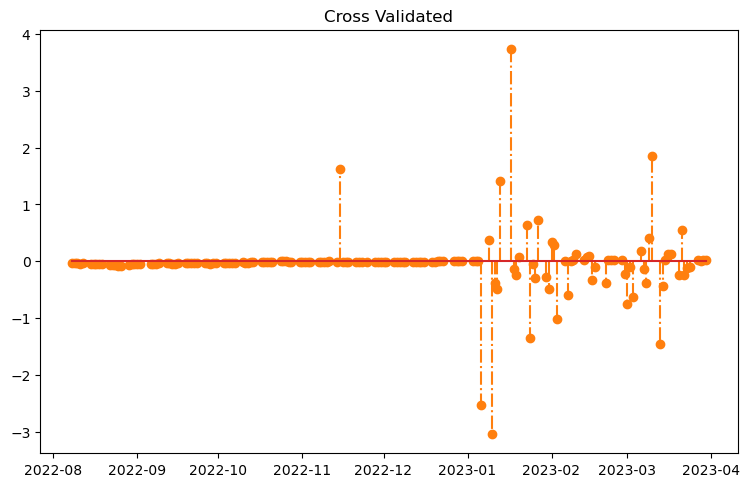


__________________________________________________________________


__________________________________________________________________

Random Forest


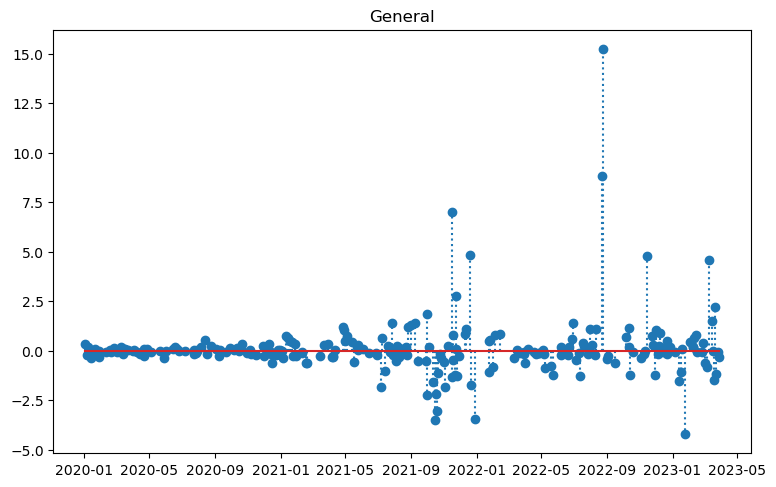

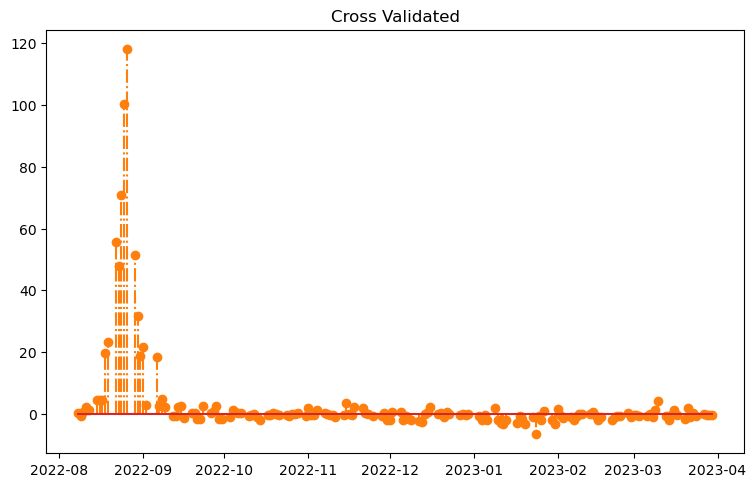


__________________________________________________________________


__________________________________________________________________

Support Vector


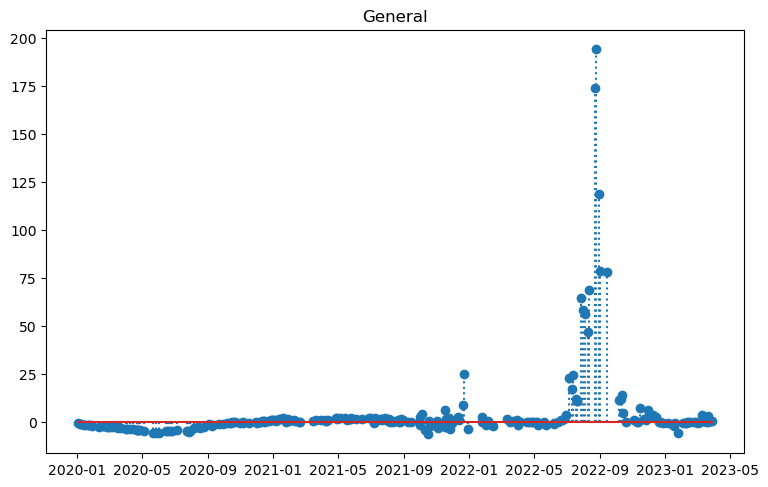

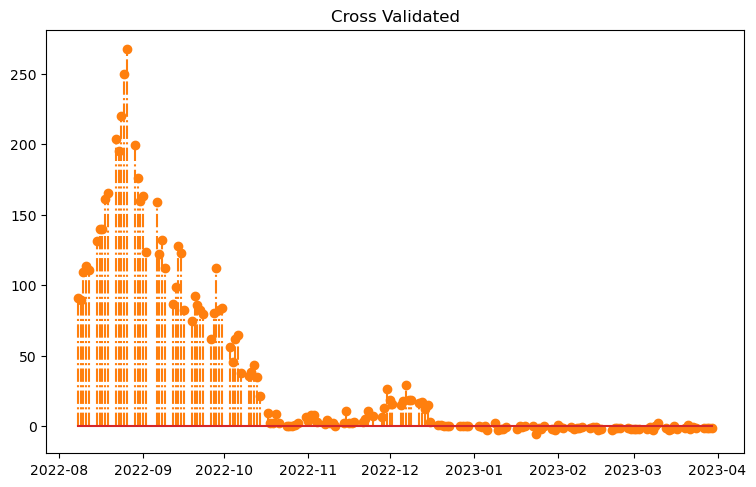


__________________________________________________________________


__________________________________________________________________

Bayesian Ridge


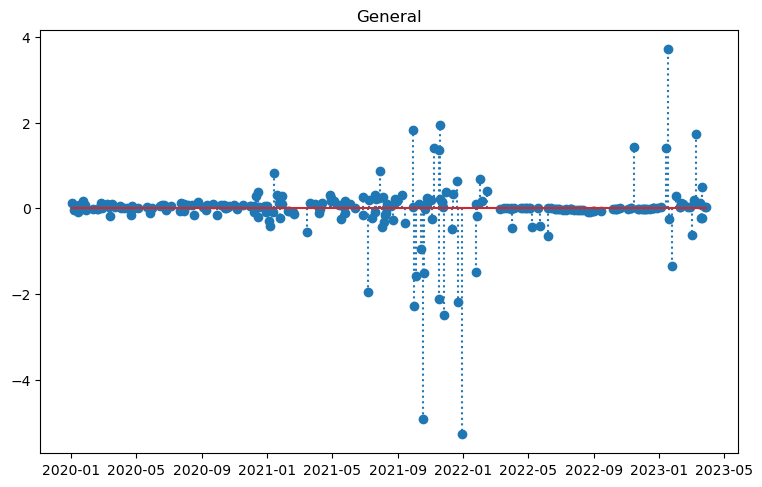

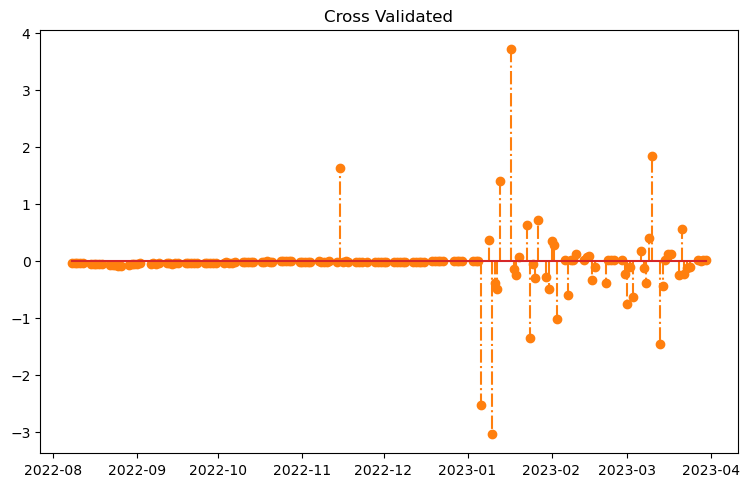


__________________________________________________________________



In [32]:
for mod_K in models_name:
    print('\n__________________________________________________________________\n')
    print(models_name[mod_K])
    models_mods_norm[mod_K].residualTest(title="General",lineformat='C0:')
    models_mods_CVKF[mod_K].residualTest(title="Cross Validated",lineformat='C1-.');
    print('\n__________________________________________________________________\n')

<a id='@29'></a>
### 29. **Specialized improvements for the models**
---
Extensive hours of studies on each algorithm's dynamics reveal that although the Cross Validation improved our models by some quantity and quality, further improvement of each model's predictive qualities could be made using specialized methods as 
1. Linear Regression and Bayesian Ridge Regression could be improved using Gradient Desent method since they are more oriented to their equation of state
2. Support Vector Machines are as their name suggests are Vector Machines and are hyperparameter oriented hence need to be boosted by their Hyperparameters
3. Random Forests are Ensemble models and are dependent on their hyperparameters thus need to be boosted by their hyperparameters.

_Hence, proceeding into making those improvements_

[🠉 Back to Contents](#@Contents)

<a id='@30'></a>
### 30. **Gradient Descent (What Why How)**
---
Gradient descent is an optimization algorithm used to find the values of parameters (coefficients) of a function (f) that minimizes a cost function (cost).
Gradient descent is best used when the parameters cannot be calculated analytically (e.g. using linear algebra) and must be searched for by an optimization algorithm


<a id='@31'></a>
### 31. **Hyperparameters Boosting (What Why How)**
---
#### What is a Model Parameter?
A model parameter is a configuration variable that is internal to the model and whose value can be estimated from data.

* They are required by the model when making predictions.
* They values define the skill of the model on your problem.
* They are estimated or learned from data.
* They are often not set manually by the practitioner.
* They are often saved as part of the learned model.

Parameters are key to machine learning algorithms. They are the part of the model that is learned from historical training data.
In classical machine learning literature, we may think of the model as the hypothesis and the parameters as the tailoring of the hypothesis to a specific set of data.
Often model parameters are estimated using an optimization algorithm, which is a type of efficient search through possible parameter values.


#### What is a Model Hyperparameter?
A model hyperparameter is a configuration that is external to the model and whose value cannot be estimated from data.

* They are often used in processes to help estimate model parameters.
* They are often specified by the practitioner.
* They can often be set using heuristics.
* They are often tuned for a given predictive modeling problem.

We cannot know the best value for a model hyperparameter on a given problem. We may use rules of thumb, copy values used on other problems, or search for the best value by trial and error.

Hyperparameters are parameters whose values control the learning process and determine the values of model parameters that a learning algorithm ends up learning. The prefix ‘hyper_’ suggests that they are ‘top-level’ parameters that control the learning process and the model parameters that result from it.

During machine learning, for designing a model, we choose and set hyperparameter values that our learning algorithm will use before the training of the model even begins. In this light, hyperparameters are said to be external to the model because the model cannot change its values during learning/training.

Hyperparameters are used by the learning algorithm when it is learning but they are not part of the resulting model. At the end of the learning process, we have the trained model parameters which effectively is what we refer to as the model. The hyperparameters that were used during training are not part of this model. We cannot for instance know what hyperparameter values were used to train a model from the model itself, we only know the model parameters that were learned.

Basically, anything in machine learning and deep learning that you decide their values or choose their configuration before training begins and whose values or configuration will remain the same when training ends is a hyperparameter.


<a id='@32'></a>
### 32. **Improving the Models (Gradient Descent & Hyperparameter Boosting Methods)**
---
Having the knowledge of working techniques of [Gradient Descent](#@30) and [Hyperparameter boosting](#@31) methods we can implement them as below.  

In [33]:
#Generating Copies 
models_imprv_GEN=deepcopy(models_mods_norm);models_imprv_CVKF=deepcopy(models_mods_CVKF);

#### Linear Regression and Bayesian Ridge Regression


In [34]:
# Linear Regression 
models_imprv_GEN['LR'].gradientEnhanced(alpha=0.01,iters=150);
models_imprv_CVKF['LR'].gradientEnhanced(alpha=0.01,iters=150);

# Bayesian Ridge Regression
models_imprv_GEN['BR'].gradientEnhanced(alpha=0.01,iters=150);
models_imprv_CVKF['BR'].gradientEnhanced(alpha=0.01,iters=150);

#### Support Vector Machines

In [35]:
parameters = {'kernel': ('linear', 'rbf','poly'), 'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.5,0.3]}
models_imprv_GEN['SV'].model=models_imprv_GEN['SV'].hyperboost(param_grid=parameters);
models_imprv_CVKF['SV'].model=models_imprv_CVKF['SV'].hyperboost(evaluator=GridSearchCV,param_grid=parameters);

#### Random Forest Regressions

In [36]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
models_imprv_GEN['RF'].model=models_imprv_GEN['RF'].hyperboost(param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 0);
models_imprv_CVKF['RF'].model=models_imprv_CVKF['RF'].hyperboost(param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 0);

<a id='@33'></a>
### 33. **How much improvement we achieved ?**
---
Since we feel like our models are trained much let us explore their accurary limits

In [37]:
for keys in models_name:
    print('\n__________________________________________________________________\n')
    improvement(models_mods_norm[keys].accuracy(),models_mods_CVKF[keys].accuracy(),models_name[keys])
    print("           Base Accuracy  : ",models_mods_norm[keys].accuracy())
    print(" Cross Validated Accuracy : ",models_mods_CVKF[keys].accuracy())
    print('\n__________________________________________________________________\n')
    improvement(models_mods_norm[keys].accuracy(),models_imprv_GEN[keys].accuracy(),models_name[keys])
    print("           Base Accuracy  : ",models_mods_norm[keys].accuracy())
    print("   Test Improved Accuracy : ",models_imprv_GEN[keys].accuracy())
    print('\n__________________________________________________________________\n')
    improvement(models_mods_CVKF[keys].accuracy(),models_imprv_CVKF[keys].accuracy(),models_name[keys])
    print("                         Base Accuracy  : ",models_mods_CVKF[keys].accuracy())
    print(" Cross Validated Test Improved Accuracy : ",models_imprv_CVKF[keys].accuracy())
    print('\n__________________________________________________________________\n')
    print('\n__________________________________________________________________\n')


__________________________________________________________________

Linear Regression
 Improved by 0.362%
           Base Accuracy  :  99.32271143537098
 Cross Validated Accuracy :  99.68262119124071

__________________________________________________________________

Linear Regression
 Improved by nan%
           Base Accuracy  :  99.32271143537098
   Test Improved Accuracy :  nan

__________________________________________________________________

Linear Regression
 Improved by nan%
                         Base Accuracy  :  99.68262119124071
 Cross Validated Test Improved Accuracy :  nan

__________________________________________________________________


__________________________________________________________________


__________________________________________________________________

Random Forest
 Improved by -1.151%
           Base Accuracy  :  98.68564760171864
 Cross Validated Accuracy :  97.54931056968233

________________________________________________________________

<a id='@34'></a>
### 34. **How much is too much ? (Accuracy and Metrics Benchmarking with Residuals)**
---
#### Model Skill Is Relative
Every predictive modeling problem is unique.
This includes the specific data we have, the tools we’re using.
Our predictive modeling problem has not been solved before. Therefore, we cannot know what a good model looks like or what skill it might have.
We might have ideas of what a skillful model looks like based on knowledge of the domain, but we don’t know whether those skill scores are achievable.
The best that we can do is to compare the performance of machine learning models on our specific data to other models also trained on the same data.
Machine learning model performance is relative and ideas of what score a good model can achieve only make sense and can only be interpreted in the context of the skill scores of other models also trained on the same data.

#### Baseline Model Skill

The results for the baseline model provide the point from which the skill of all other models trained on the data can be evaluated.
Three examples of baseline models include:
* Predict the mean outcome value for a regression problem.
* Predict the mode outcome value for a classification problem.
* Predict the input as the output (called persistence) for a univariate time series forecasting problem.

The baseline performance on our problem can then be used as the yardstick by which all other models can be compared and evaluated.
If a model achieves a performance below the baseline, something is wrong (e.g. there’s a bug) or the model is not appropriate for your problem.
#### What Is the Best Score?
If we are working on a classification problem, the best score is 100% accuracy.
If we are working on a regression problem, the best score is 0.0 error.
These scores are an impossible to achieve upper/lower bound. All predictive modeling problems have prediction error. Expecting it is cleverer. The error comes from a range of sources such as:
* Incompleteness of data sample.
* Noise in the data.
* Stochastic nature of the modeling algorithm.

We cannot achieve the best score, but it is good to know what the best possible performance is for our chosen measure. 

#### Discover Limits of Model Skill
Once we have the baseline, we can explore the extent of model performance on our predictive modeling problem.
In fact, this is the hard work and the objective of the project: to find a model that we can demonstrate, works reliably well in making predictions on our specific dataset.
There are many strategies to this problem; two that we might wish to consider are:
* Start High. Select a machine learning method that is sophisticated and known to perform well on a range of predictive model problems, such as random forest or gradient boosting. We need to evaluate the model on our problem and use the result as an approximate top-end benchmark, then find the simplest model that achieves similar performance.
* Exhaustive Search. Evaluate all of the machine learning methods that one can think of on the problem and select the method that achieves the best performance relative to the baseline.

The “Start High” approach is fast and can help us define the bounds of model skill to expect on the problem and find a simple (e.g. Occam’s Razor) model that can achieve similar results. It can also help you find out whether the problem is solvable/predictable fast, which is important because not all problems are predictable.

The “Exhaustive Search” is slow and is really intended for long-running projects where model skill is more important than almost any other concern. I often perform variations of this approach testing suites of similar methods in batches and call it the spot-checking approach.

Both methods will give us a population of model performance scores that you can compare to the baseline.


<a id='@35'></a>
### 35. **Best of Models and Implementation**
---
Understanding that there may be a better model among the ones we studied our choice of model goes to the Hyperparameter boosted Cross Validated model of the Support Vector Regressor Machine 


__________________________________________________________________

Support VectorHyperparameter boosted Cross Validated model governing parameters
 	C	:	10
 	cache_size	:	200
 	coef0	:	0.0
 	degree	:	3
 	epsilon	:	0.5
 	gamma	:	1e-07
 	kernel	:	linear
 	max_iter	:	-1
 	shrinking	:	True
 	tol	:	0.001
 	verbose	:	False

__________________________________________________________________



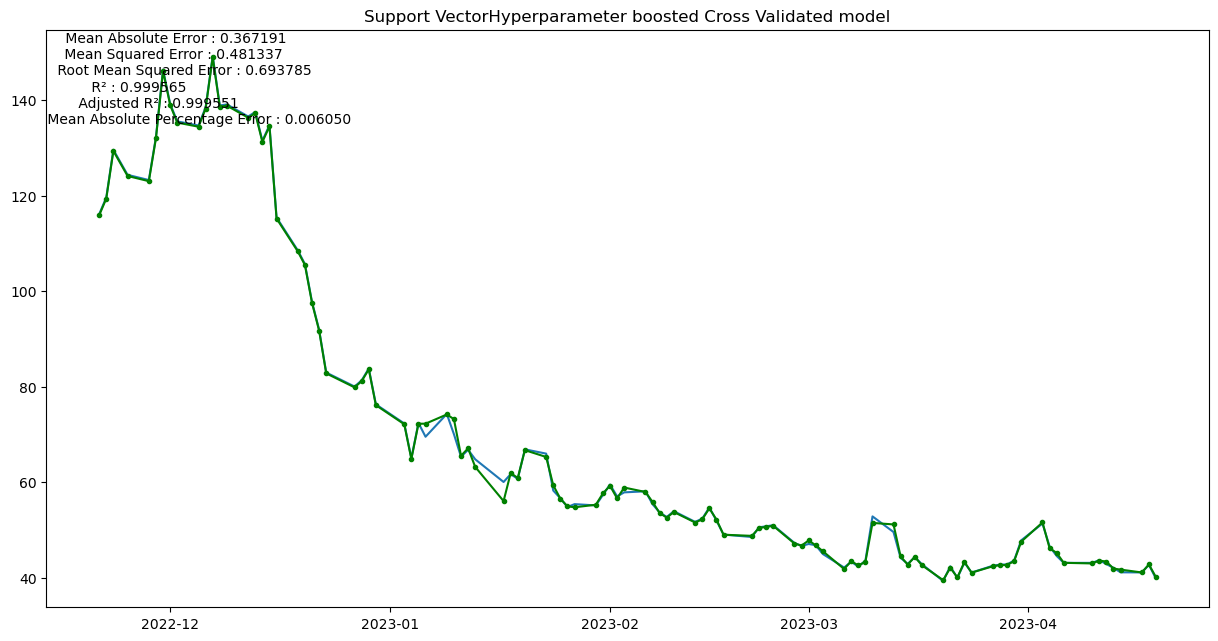

In [38]:
stockCandle(dhR,'Most Current Natural Gas TTF Prices');
title_string=models_name['SV']+'Hyperparameter boosted Cross Validated model'
best_mod_params=models_imprv_CVKF['SV'].model.get_params()
print("\n__________________________________________________________________\n");print(title_string,'governing parameters');
for k in best_mod_params:
    print(" ",k,":",best_mod_params[k],sep='\t')
print("\n__________________________________________________________________\n");
models_imprv_CVKF['SV'].plotMetrics(dhR,title=title_string)

# Prediction Forward Prices using Neural Networked Algorithm - LSTM

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. 
Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points, but also entire sequences of data.

<b>LSTM models are able to store information over a period of time.</b>
In order words, they have a memory capacity. 

Remember that LSTM stands for Long Short-Term Memory Model.

This characteristic is extremely useful when we deal with Time-Series or Sequential Data. When using an LSTM model we are free and able to decide what information will be stored and what discarded. We do that using the “gates”. The deep understanding of the LSTM is outside the scope of this post but if you are interested in learning more, have a look at the references at the end of this post.

## LSTM model training

#### Pre-processing data with MinMaxScaler

In [39]:
dHs['Date'] = dHs.index

In [40]:
df = dHs[["Date", "Close"]]
df=df.reset_index(drop=True)

In [41]:
df.head()

,Date,Close
0,2020-01-02,12.075
1,2020-01-03,12.985
2,2020-01-06,12.280
3,2020-01-07,11.930
4,2020-01-08,11.965


In [42]:
df.Date = pd.to_datetime(df.Date)

In [43]:
df = df.set_index("Date")
df.head()

,Close
Date,
2020-01-02,12.075
2020-01-03,12.985
2020-01-06,12.280
2020-01-07,11.930
2020-01-08,11.965


In [44]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2)

In [45]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [46]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

Before creating the LSTM model, we need to create a Time Series Generator object.

In [47]:
#pip install tensorflow

In [48]:
from keras.preprocessing.sequence import TimeseriesGenerator
# Let's redefine to get 24 days  back and then predict the next day out
n_input = 24
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, 
                                length=n_input, batch_size=1)

#### Example of transformation

In [49]:
X,y = generator[0]

In [50]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[3.12890602e-01 6.30797786e-02 2.31913150e-02 1.15670594e-01
 1.54587911e-01 5.51110070e-04 2.37275312e-02 5.87703979e-01
 3.49880532e-02 1.59970922e-02 3.26942416e-02 1.42543921e-02
 2.04965355e-01 2.62185493e-01 2.12341289e-01 8.11025764e-02
 2.19997264e-02 2.60413000e-01 2.19020139e-01 2.45649199e-01
 4.42973449e-02 6.95590433e-03 1.96683787e-01 4.48657346e-01]
Predict this y: 
 [[0.0165631]]


# Single LSTM Model

In [51]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [52]:
lstm_model.fit(generator,epochs=20)

Epoch 1/20


2023-04-20 00:05:43.846802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


630/630 [==============================] - 5s 5ms/step - loss: 0.0352
Epoch 2/20
630/630 [==============================] - 3s 5ms/step - loss: 0.0340
Epoch 3/20
630/630 [==============================] - 3s 5ms/step - loss: 0.0340
Epoch 4/20
630/630 [==============================] - 3s 5ms/step - loss: 0.0338
Epoch 5/20
630/630 [==============================] - 4s 6ms/step - loss: 0.0334
Epoch 6/20
630/630 [==============================] - 4s 7ms/step - loss: 0.0339
Epoch 7/20
630/630 [==============================] - 4s 6ms/step - loss: 0.0337
Epoch 8/20
630/630 [==============================] - 4s 7ms/step - loss: 0.0334
Epoch 9/20
630/630 [==============================] - 4s 6ms/step - loss: 0.0336
Epoch 10/20
630/630 [==============================] - 4s 6ms/step - loss: 0.0335
Epoch 11/20
630/630 [==============================] - 4s 6ms/step - loss: 0.0335
Epoch 12/20
630/630 [==============================] - 4s 6ms/step - loss: 0.0335
Epoch 13/20
630/630 [===============

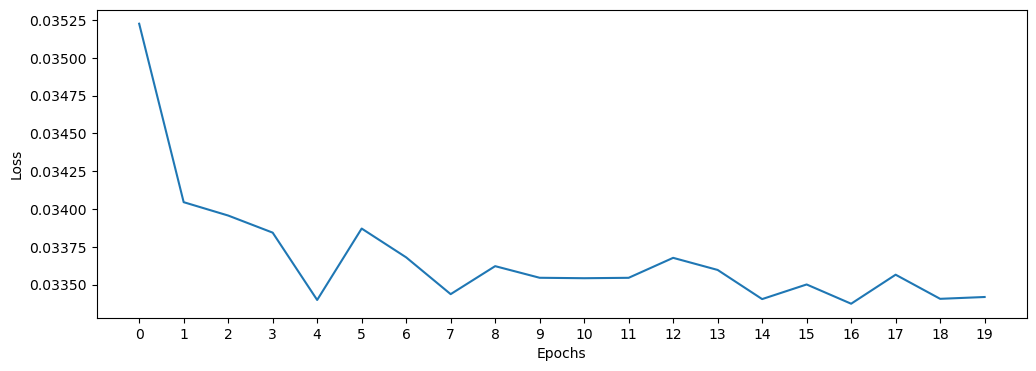

In [53]:
import matplotlib.pyplot as plt

losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

## Prediction on test data

Next we are going to make a prediction for 12 days (12 predictions). To do this we will do the following:
- create an empty list for each of our 12 predictions
- create the batch that our model will predict
- save the prediction in our list
- add the prediction to the end of the batch to use it in the next prediction

In [54]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step


As you know, we scale our data, so we have to invert it to see true predictions.

In [55]:
lstm_predictions_scaled

[array([0.17294784], dtype=float32),
 array([0.17311586], dtype=float32),
 array([0.17314106], dtype=float32),
 array([0.17325215], dtype=float32),
 array([0.17337358], dtype=float32),
 array([0.1734822], dtype=float32),
 array([0.17357203], dtype=float32),
 array([0.1736424], dtype=float32),
 array([0.17369607], dtype=float32),
 array([0.17373575], dtype=float32),
 array([0.1737659], dtype=float32),
 array([0.17378819], dtype=float32),
 array([0.17380396], dtype=float32),
 array([0.1738151], dtype=float32),
 array([0.17382392], dtype=float32),
 array([0.17383027], dtype=float32),
 array([0.1738351], dtype=float32),
 array([0.17383856], dtype=float32),
 array([0.17384088], dtype=float32),
 array([0.17384297], dtype=float32),
 array([0.17384444], dtype=float32),
 array([0.17384566], dtype=float32),
 array([0.17384689], dtype=float32),
 array([0.17384683], dtype=float32),
 array([0.17384672], dtype=float32),
 array([0.17384674], dtype=float32),
 array([0.17384675], dtype=float32),
 array

In [56]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [57]:
lstm_predictions

array([[61.56617073],
       [61.62257454],
       [61.63103311],
       [61.66832385],
       [61.70908606],
       [61.74554645],
       [61.77570418],
       [61.79932415],
       [61.81734175],
       [61.83066238],
       [61.84078165],
       [61.84826481],
       [61.85355704],
       [61.85729862],
       [61.86025987],
       [61.86239077],
       [61.86401145],
       [61.86517194],
       [61.86595227],
       [61.86665257],
       [61.86714778],
       [61.86755795],
       [61.86796812],
       [61.86794811],
       [61.8679131 ],
       [61.8679181 ],
       [61.8679231 ],
       [61.86792811],
       [61.86793311],
       [61.86793311],
       [61.86793311],
       [61.86793811],
       [61.86793811],
       [61.86793811],
       [61.86793811],
       [61.86793311],
       [61.86793311],
       [61.86793811],
       [61.86793311],
       [61.86793311],
       [61.86793311],
       [61.86793311],
       [61.86793311],
       [61.86793311],
       [61.86793311],
       [61

In [58]:
test_data['LSTM_Predictions'] = lstm_predictions

In [59]:
test_data

,Close,LSTM_Predictions
Date,,
2020-07-07,6.125000,61.566171
2022-03-21,96.302002,61.622575
2020-12-07,14.355000,61.631033
2021-05-17,26.309999,61.668324
2021-08-09,42.785999,61.709086
...,...,...
2021-04-01,19.170000,61.867933
2022-05-16,92.860001,61.867933
2022-09-14,217.882004,61.867933


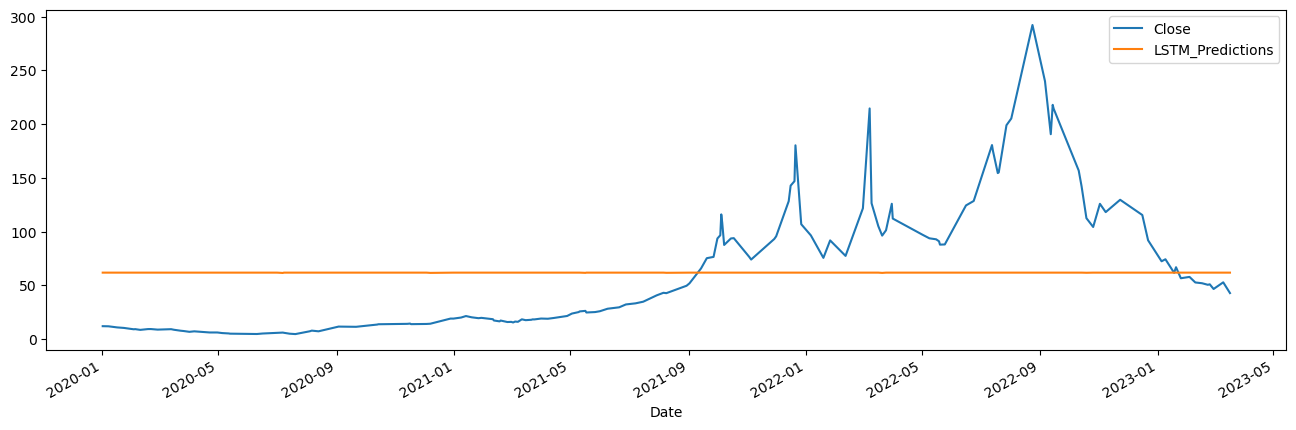

In [60]:
test_data['Close'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [61]:
from statsmodels.tools.eval_measures import rmse

lstm_rmse_error = rmse(test_data['Close'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Close'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 3496.1150892633677
RMSE Error: 59.12795522646938
Mean: 62.642375338048396


##  Double LSTM Model


In [62]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu',return_sequences=True,
                    input_shape=(n_input, n_features)))
lstm_model.add(LSTM(200, return_sequences=True))
lstm_model.add(Dropout(rate=0.2))
lstm_model.add(LSTM(200, return_sequences=False))
lstm_model.add(Dense(1))

mc = ModelCheckpoint('double_model_lstm.h5', monitor='val_loss', mode='min', 
                     verbose=1, save_best_only=True)

lstm_model.summary()

2023-04-20 00:07:24.992462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-20 00:07:24.994602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-20 00:07:24.996244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24, 200)           161600    
                                                                 
 lstm_2 (LSTM)               (None, 24, 200)           320800    
                                                                 
 dropout (Dropout)           (None, 24, 200)           0         
                                                                 
 lstm_3 (LSTM)               (None, 200)               320800    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 803,401
Trainable params: 803,401
Non-trainable params: 0
_________________________________________________________________


2023-04-20 00:07:25.299728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-20 00:07:25.301718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-20 00:07:25.303381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [63]:
lstm_model.compile(optimizer='adam', loss='mse')

In [64]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20


2023-04-20 00:07:25.553715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-20 00:07:26.249865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-20 00:07:26.253681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

630/630 [==============================] - 28s 36ms/step - loss: 0.0357
Epoch 2/20
630/630 [==============================] - 23s 36ms/step - loss: 0.0340
Epoch 3/20
630/630 [==============================] - 25s 40ms/step - loss: 0.0340
Epoch 4/20
630/630 [==============================] - 24s 38ms/step - loss: 0.0335
Epoch 5/20
630/630 [==============================] - 25s 40ms/step - loss: 0.0341
Epoch 6/20
630/630 [==============================] - 21s 33ms/step - loss: 0.0333
Epoch 7/20
630/630 [==============================] - 22s 36ms/step - loss: 0.0341
Epoch 8/20
630/630 [==============================] - 27s 42ms/step - loss: 0.0339
Epoch 9/20
630/630 [==============================] - 24s 38ms/step - loss: 0.0337
Epoch 10/20
630/630 [==============================] - 24s 39ms/step - loss: 0.0339
Epoch 11/20
630/630 [==============================] - 24s 37ms/step - loss: 0.0337
Epoch 12/20
630/630 [==============================] - 30s 47ms/step - loss: 0.0336
Epoch 13/20


### EarlyStopping y Validation Generator 

In [65]:
from tensorflow.keras.callbacks import EarlyStopping

In [66]:
early_stop = EarlyStopping(monitor='val_loss',patience=12)

In [67]:
validation_generator = TimeseriesGenerator(scaled_test_data,scaled_test_data, length=n_input)

In [68]:
lstm_model.compile(optimizer='adam', loss='mse')

In [69]:
# fit model
lstm_model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop, mc])

Epoch 1/20


2023-04-20 00:15:58.689352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-20 00:15:58.930951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-20 00:15:58.932546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

630/630 [==============================] - ETA: 0s - loss: 0.0336

2023-04-20 00:16:26.829036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-20 00:16:27.193902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-20 00:16:27.195606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra


Epoch 1: val_loss improved from inf to 0.03274, saving model to double_model_lstm.h5
630/630 [==============================] - 29s 41ms/step - loss: 0.0336 - val_loss: 0.0327
Epoch 2/20
629/630 [============================>.] - ETA: 0s - loss: 0.0334
Epoch 2: val_loss did not improve from 0.03274
630/630 [==============================] - 25s 40ms/step - loss: 0.0333 - val_loss: 0.0331
Epoch 3/20
629/630 [============================>.] - ETA: 0s - loss: 0.0334
Epoch 3: val_loss did not improve from 0.03274
630/630 [==============================] - 26s 41ms/step - loss: 0.0334 - val_loss: 0.0330
Epoch 4/20
629/630 [============================>.] - ETA: 0s - loss: 0.0334
Epoch 4: val_loss improved from 0.03274 to 0.03261, saving model to double_model_lstm.h5
630/630 [==============================] - 23s 36ms/step - loss: 0.0334 - val_loss: 0.0326
Epoch 5/20
629/630 [============================>.] - ETA: 0s - loss: 0.0333
Epoch 5: val_loss did not improve from 0.03261
630/630 [===

#### Learning curve

<Axes: >

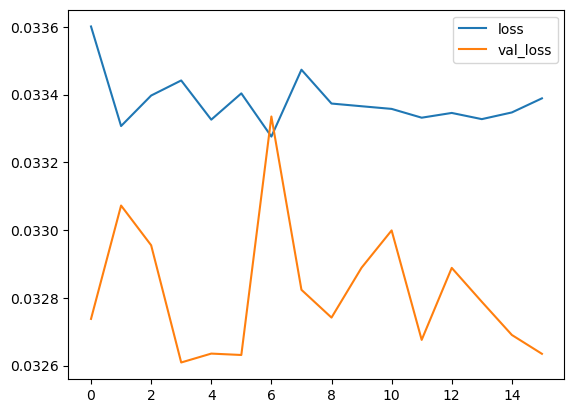

In [70]:
losses = pd.DataFrame(lstm_model.history.history)
losses.plot()

In [71]:
from keras.models import load_model

lstm_model = load_model('double_model_lstm.h5', compile=False)

2023-04-20 00:22:59.560663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-20 00:22:59.562270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-20 00:22:59.563464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

WARNING:tensorflow:Layer lstm_1 will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.

## Prediction on test data

In [72]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    lstm_pred = lstm_model.predict(current_batch)[0]
    
    # store prediction
    lstm_predictions_scaled.append(lstm_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

2023-04-20 00:23:00.066663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-20 00:23:00.068170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-20 00:23:00.069270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 22ms/step


As you know, we scale our data, so we have to invert it to see true predictions.

### Reverse the transformation


In [73]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [74]:
test_data['LSTM_Predictions'] = lstm_predictions

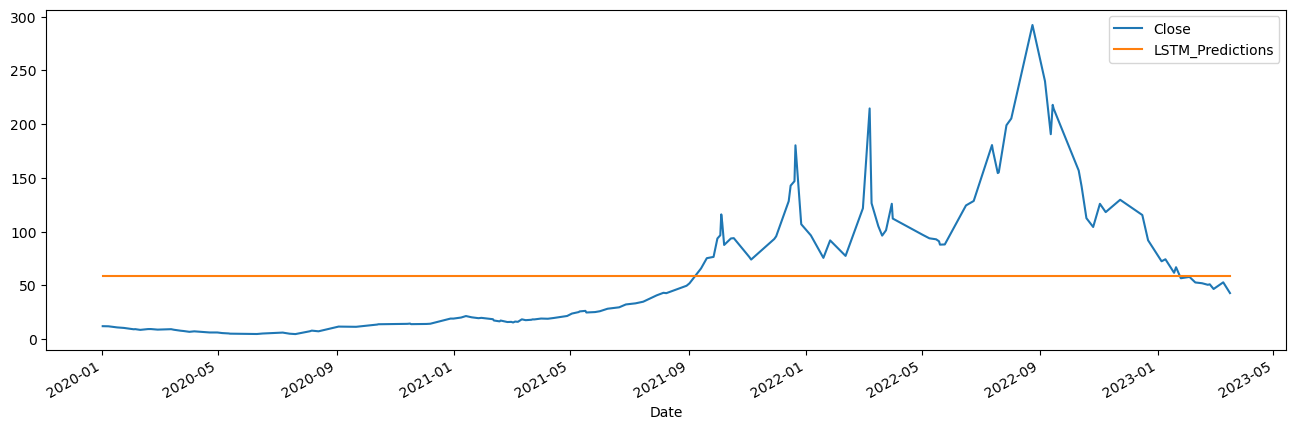

In [75]:
test_data['Close'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [76]:
lstm_rmse_error = rmse(test_data['Close'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Close'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 3488.8178386690392
RMSE Error: 59.06621571312182
Mean: 62.642375338048396


# Real Prediction of the Gas Price of the next week

Let us assume that we want to predict the price of the gas of the next week.

In [77]:
df.head()

,Close
Date,
2020-01-02,12.075
2020-01-03,12.985
2020-01-06,12.280
2020-01-07,11.930
2020-01-08,11.965


In [78]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [79]:
length = 7 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [80]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8


2023-04-20 00:23:12.279349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


811/811 [==============================] - 4s 3ms/step - loss: 0.0032
Epoch 2/8
811/811 [==============================] - 3s 4ms/step - loss: 0.0015
Epoch 3/8
811/811 [==============================] - 4s 5ms/step - loss: 0.0012
Epoch 4/8
811/811 [==============================] - 4s 5ms/step - loss: 0.0012
Epoch 5/8
811/811 [==============================] - 4s 5ms/step - loss: 0.0012
Epoch 6/8
811/811 [==============================] - 3s 4ms/step - loss: 9.6276e-04
Epoch 7/8
811/811 [==============================] - 4s 5ms/step - loss: 0.0010
Epoch 8/8
811/811 [==============================] - 4s 4ms/step - loss: 9.4919e-04


In [81]:
forecast = []
# Replace periods with whatever forecast length you want
#one week
periods = 7

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


In [82]:
forecast = scaler.inverse_transform(forecast)

In [83]:
test_data.tail()

,Close,LSTM_Predictions
Date,,
2021-04-01,19.170000,59.174306
2022-05-16,92.860001,59.174306
2022-09-14,217.882004,59.174306
2022-11-02,125.862999,59.174306
2021-12-27,106.892998,59.174306


In [84]:
from datetime import date
from datetime import datetime
import time
import warnings
warnings.filterwarnings("ignore")

today = date.today()
print("Today's date:", today)
to_today = datetime.strptime(str(today), '%Y-%m-%d').strftime('%d/%m/%Y')
to_date = datetime.strptime(str(today), '%Y-%m-%d').strftime('%Y-%m-%d')

Today's date: 2023-04-20


In [85]:
def addonDays(a, x):
   ret = time.strftime("%Y-%m-%d",time.localtime(time.mktime(time.strptime(a,"%Y-%m-%d"))+x*3600*24+3600))      
   return ret

In [86]:
week_ago=addonDays(to_date, -7)

In [87]:
next_week=addonDays(to_date, 7)

In [88]:
next_month=addonDays(to_date, 30)

In [89]:
forecast_index = pd.date_range(start=to_date,periods=periods,freq='D')

In [90]:
forecast_index

DatetimeIndex(['2023-04-20', '2023-04-21', '2023-04-22', '2023-04-23',
               '2023-04-24', '2023-04-25', '2023-04-26'],
              dtype='datetime64[ns]', freq='D')

In [91]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])
forecast_df

,Forecast
2023-04-20,39.532000
2023-04-21,37.965441
2023-04-22,36.353296
2023-04-23,34.726847
2023-04-24,33.063527
2023-04-25,31.372876
2023-04-26,29.666358


<Axes: xlabel='Date'>

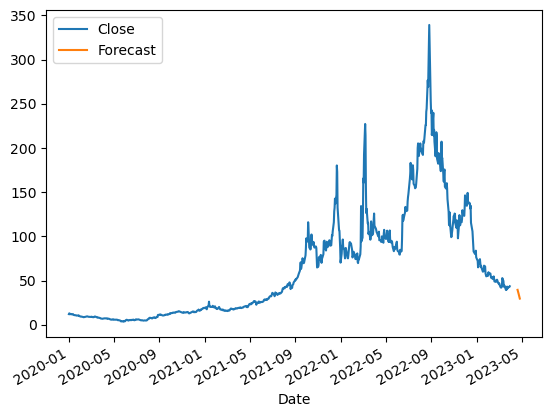

In [92]:
ax = df.plot()
forecast_df.plot(ax=ax)

In [93]:
month_ago=addonDays(to_date, -30)

ConversionError: Failed to convert value(s) to axis units: array([Timestamp('2020-01-02 00:00:00'), Timestamp('2020-01-03 00:00:00'),
       Timestamp('2020-01-06 00:00:00'), Timestamp('2020-01-07 00:00:00'),
       Timestamp('2020-01-08 00:00:00'), Timestamp('2020-01-09 00:00:00'),
       Timestamp('2020-01-10 00:00:00'), Timestamp('2020-01-13 00:00:00'),
       Timestamp('2020-01-14 00:00:00'), Timestamp('2020-01-15 00:00:00'),
       Timestamp('2020-01-16 00:00:00'), Timestamp('2020-01-17 00:00:00'),
       Timestamp('2020-01-21 00:00:00'), Timestamp('2020-01-22 00:00:00'),
       Timestamp('2020-01-23 00:00:00'), Timestamp('2020-01-24 00:00:00'),
       Timestamp('2020-01-27 00:00:00'), Timestamp('2020-01-28 00:00:00'),
       Timestamp('2020-01-29 00:00:00'), Timestamp('2020-01-30 00:00:00'),
       Timestamp('2020-01-31 00:00:00'), Timestamp('2020-02-03 00:00:00'),
       Timestamp('2020-02-04 00:00:00'), Timestamp('2020-02-05 00:00:00'),
       Timestamp('2020-02-06 00:00:00'), Timestamp('2020-02-07 00:00:00'),
       Timestamp('2020-02-10 00:00:00'), Timestamp('2020-02-11 00:00:00'),
       Timestamp('2020-02-12 00:00:00'), Timestamp('2020-02-13 00:00:00'),
       Timestamp('2020-02-14 00:00:00'), Timestamp('2020-02-18 00:00:00'),
       Timestamp('2020-02-19 00:00:00'), Timestamp('2020-02-20 00:00:00'),
       Timestamp('2020-02-21 00:00:00'), Timestamp('2020-02-24 00:00:00'),
       Timestamp('2020-02-25 00:00:00'), Timestamp('2020-02-26 00:00:00'),
       Timestamp('2020-02-27 00:00:00'), Timestamp('2020-02-28 00:00:00'),
       Timestamp('2020-03-02 00:00:00'), Timestamp('2020-03-03 00:00:00'),
       Timestamp('2020-03-04 00:00:00'), Timestamp('2020-03-05 00:00:00'),
       Timestamp('2020-03-06 00:00:00'), Timestamp('2020-03-09 00:00:00'),
       Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-11 00:00:00'),
       Timestamp('2020-03-12 00:00:00'), Timestamp('2020-03-13 00:00:00'),
       Timestamp('2020-03-16 00:00:00'), Timestamp('2020-03-17 00:00:00'),
       Timestamp('2020-03-18 00:00:00'), Timestamp('2020-03-19 00:00:00'),
       Timestamp('2020-03-20 00:00:00'), Timestamp('2020-03-23 00:00:00'),
       Timestamp('2020-03-24 00:00:00'), Timestamp('2020-03-25 00:00:00'),
       Timestamp('2020-03-26 00:00:00'), Timestamp('2020-03-27 00:00:00'),
       Timestamp('2020-03-30 00:00:00'), Timestamp('2020-03-31 00:00:00'),
       Timestamp('2020-04-01 00:00:00'), Timestamp('2020-04-02 00:00:00'),
       Timestamp('2020-04-03 00:00:00'), Timestamp('2020-04-06 00:00:00'),
       Timestamp('2020-04-07 00:00:00'), Timestamp('2020-04-08 00:00:00'),
       Timestamp('2020-04-09 00:00:00'), Timestamp('2020-04-13 00:00:00'),
       Timestamp('2020-04-14 00:00:00'), Timestamp('2020-04-15 00:00:00'),
       Timestamp('2020-04-16 00:00:00'), Timestamp('2020-04-17 00:00:00'),
       Timestamp('2020-04-20 00:00:00'), Timestamp('2020-04-21 00:00:00'),
       Timestamp('2020-04-22 00:00:00'), Timestamp('2020-04-23 00:00:00'),
       Timestamp('2020-04-24 00:00:00'), Timestamp('2020-04-27 00:00:00'),
       Timestamp('2020-04-28 00:00:00'), Timestamp('2020-04-29 00:00:00'),
       Timestamp('2020-04-30 00:00:00'), Timestamp('2020-05-01 00:00:00'),
       Timestamp('2020-05-04 00:00:00'), Timestamp('2020-05-05 00:00:00'),
       Timestamp('2020-05-06 00:00:00'), Timestamp('2020-05-07 00:00:00'),
       Timestamp('2020-05-08 00:00:00'), Timestamp('2020-05-11 00:00:00'),
       Timestamp('2020-05-12 00:00:00'), Timestamp('2020-05-13 00:00:00'),
       Timestamp('2020-05-14 00:00:00'), Timestamp('2020-05-15 00:00:00'),
       Timestamp('2020-05-18 00:00:00'), Timestamp('2020-05-19 00:00:00'),
       Timestamp('2020-05-20 00:00:00'), Timestamp('2020-05-21 00:00:00'),
       Timestamp('2020-05-22 00:00:00'), Timestamp('2020-05-26 00:00:00'),
       Timestamp('2020-05-27 00:00:00'), Timestamp('2020-05-28 00:00:00'),
       Timestamp('2020-05-29 00:00:00'), Timestamp('2020-06-01 00:00:00'),
       Timestamp('2020-06-02 00:00:00'), Timestamp('2020-06-03 00:00:00'),
       Timestamp('2020-06-04 00:00:00'), Timestamp('2020-06-05 00:00:00'),
       Timestamp('2020-06-08 00:00:00'), Timestamp('2020-06-09 00:00:00'),
       Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-11 00:00:00'),
       Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-15 00:00:00'),
       Timestamp('2020-06-16 00:00:00'), Timestamp('2020-06-17 00:00:00'),
       Timestamp('2020-06-18 00:00:00'), Timestamp('2020-06-19 00:00:00'),
       Timestamp('2020-06-22 00:00:00'), Timestamp('2020-06-23 00:00:00'),
       Timestamp('2020-06-24 00:00:00'), Timestamp('2020-06-25 00:00:00'),
       Timestamp('2020-06-26 00:00:00'), Timestamp('2020-06-29 00:00:00'),
       Timestamp('2020-06-30 00:00:00'), Timestamp('2020-07-01 00:00:00'),
       Timestamp('2020-07-02 00:00:00'), Timestamp('2020-07-06 00:00:00'),
       Timestamp('2020-07-07 00:00:00'), Timestamp('2020-07-08 00:00:00'),
       Timestamp('2020-07-09 00:00:00'), Timestamp('2020-07-10 00:00:00'),
       Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-14 00:00:00'),
       Timestamp('2020-07-15 00:00:00'), Timestamp('2020-07-16 00:00:00'),
       Timestamp('2020-07-17 00:00:00'), Timestamp('2020-07-20 00:00:00'),
       Timestamp('2020-07-21 00:00:00'), Timestamp('2020-07-22 00:00:00'),
       Timestamp('2020-07-23 00:00:00'), Timestamp('2020-07-24 00:00:00'),
       Timestamp('2020-07-27 00:00:00'), Timestamp('2020-07-28 00:00:00'),
       Timestamp('2020-07-29 00:00:00'), Timestamp('2020-07-30 00:00:00'),
       Timestamp('2020-07-31 00:00:00'), Timestamp('2020-08-03 00:00:00'),
       Timestamp('2020-08-04 00:00:00'), Timestamp('2020-08-05 00:00:00'),
       Timestamp('2020-08-06 00:00:00'), Timestamp('2020-08-07 00:00:00'),
       Timestamp('2020-08-10 00:00:00'), Timestamp('2020-08-11 00:00:00'),
       Timestamp('2020-08-12 00:00:00'), Timestamp('2020-08-13 00:00:00'),
       Timestamp('2020-08-14 00:00:00'), Timestamp('2020-08-17 00:00:00'),
       Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'),
       Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'),
       Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-25 00:00:00'),
       Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'),
       Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-31 00:00:00'),
       Timestamp('2020-09-01 00:00:00'), Timestamp('2020-09-02 00:00:00'),
       Timestamp('2020-09-03 00:00:00'), Timestamp('2020-09-04 00:00:00'),
       Timestamp('2020-09-08 00:00:00'), Timestamp('2020-09-09 00:00:00'),
       Timestamp('2020-09-10 00:00:00'), Timestamp('2020-09-11 00:00:00'),
       Timestamp('2020-09-14 00:00:00'), Timestamp('2020-09-15 00:00:00'),
       Timestamp('2020-09-16 00:00:00'), Timestamp('2020-09-17 00:00:00'),
       Timestamp('2020-09-18 00:00:00'), Timestamp('2020-09-21 00:00:00'),
       Timestamp('2020-09-22 00:00:00'), Timestamp('2020-09-23 00:00:00'),
       Timestamp('2020-09-24 00:00:00'), Timestamp('2020-09-25 00:00:00'),
       Timestamp('2020-09-28 00:00:00'), Timestamp('2020-09-29 00:00:00'),
       Timestamp('2020-09-30 00:00:00'), Timestamp('2020-10-01 00:00:00'),
       Timestamp('2020-10-02 00:00:00'), Timestamp('2020-10-05 00:00:00'),
       Timestamp('2020-10-06 00:00:00'), Timestamp('2020-10-07 00:00:00'),
       Timestamp('2020-10-08 00:00:00'), Timestamp('2020-10-09 00:00:00'),
       Timestamp('2020-10-12 00:00:00'), Timestamp('2020-10-13 00:00:00'),
       Timestamp('2020-10-14 00:00:00'), Timestamp('2020-10-15 00:00:00'),
       Timestamp('2020-10-16 00:00:00'), Timestamp('2020-10-19 00:00:00'),
       Timestamp('2020-10-20 00:00:00'), Timestamp('2020-10-21 00:00:00'),
       Timestamp('2020-10-22 00:00:00'), Timestamp('2020-10-23 00:00:00'),
       Timestamp('2020-10-26 00:00:00'), Timestamp('2020-10-27 00:00:00'),
       Timestamp('2020-10-28 00:00:00'), Timestamp('2020-10-29 00:00:00'),
       Timestamp('2020-10-30 00:00:00'), Timestamp('2020-11-02 00:00:00'),
       Timestamp('2020-11-03 00:00:00'), Timestamp('2020-11-04 00:00:00'),
       Timestamp('2020-11-05 00:00:00'), Timestamp('2020-11-06 00:00:00'),
       Timestamp('2020-11-09 00:00:00'), Timestamp('2020-11-10 00:00:00'),
       Timestamp('2020-11-11 00:00:00'), Timestamp('2020-11-12 00:00:00'),
       Timestamp('2020-11-13 00:00:00'), Timestamp('2020-11-16 00:00:00'),
       Timestamp('2020-11-17 00:00:00'), Timestamp('2020-11-18 00:00:00'),
       Timestamp('2020-11-19 00:00:00'), Timestamp('2020-11-20 00:00:00'),
       Timestamp('2020-11-23 00:00:00'), Timestamp('2020-11-24 00:00:00'),
       Timestamp('2020-11-25 00:00:00'), Timestamp('2020-11-27 00:00:00'),
       Timestamp('2020-11-30 00:00:00'), Timestamp('2020-12-01 00:00:00'),
       Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-03 00:00:00'),
       Timestamp('2020-12-04 00:00:00'), Timestamp('2020-12-07 00:00:00'),
       Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-09 00:00:00'),
       Timestamp('2020-12-10 00:00:00'), Timestamp('2020-12-11 00:00:00'),
       Timestamp('2020-12-14 00:00:00'), Timestamp('2020-12-15 00:00:00'),
       Timestamp('2020-12-16 00:00:00'), Timestamp('2020-12-17 00:00:00'),
       Timestamp('2020-12-18 00:00:00'), Timestamp('2020-12-21 00:00:00'),
       Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'),
       Timestamp('2020-12-24 00:00:00'), Timestamp('2020-12-28 00:00:00'),
       Timestamp('2020-12-29 00:00:00'), Timestamp('2020-12-30 00:00:00'),
       Timestamp('2020-12-31 00:00:00'), Timestamp('2021-01-04 00:00:00'),
       Timestamp('2021-01-05 00:00:00'), Timestamp('2021-01-06 00:00:00'),
       Timestamp('2021-01-07 00:00:00'), Timestamp('2021-01-08 00:00:00'),
       Timestamp('2021-01-11 00:00:00'), Timestamp('2021-01-12 00:00:00'),
       Timestamp('2021-01-13 00:00:00'), Timestamp('2021-01-14 00:00:00'),
       Timestamp('2021-01-15 00:00:00'), Timestamp('2021-01-19 00:00:00'),
       Timestamp('2021-01-20 00:00:00'), Timestamp('2021-01-21 00:00:00'),
       Timestamp('2021-01-22 00:00:00'), Timestamp('2021-01-25 00:00:00'),
       Timestamp('2021-01-26 00:00:00'), Timestamp('2021-01-27 00:00:00'),
       Timestamp('2021-01-28 00:00:00'), Timestamp('2021-01-29 00:00:00'),
       Timestamp('2021-02-01 00:00:00'), Timestamp('2021-02-02 00:00:00'),
       Timestamp('2021-02-03 00:00:00'), Timestamp('2021-02-04 00:00:00'),
       Timestamp('2021-02-05 00:00:00'), Timestamp('2021-02-08 00:00:00'),
       Timestamp('2021-02-09 00:00:00'), Timestamp('2021-02-10 00:00:00'),
       Timestamp('2021-02-11 00:00:00'), Timestamp('2021-02-12 00:00:00'),
       Timestamp('2021-02-16 00:00:00'), Timestamp('2021-02-17 00:00:00'),
       Timestamp('2021-02-18 00:00:00'), Timestamp('2021-02-19 00:00:00'),
       Timestamp('2021-02-22 00:00:00'), Timestamp('2021-02-23 00:00:00'),
       Timestamp('2021-02-24 00:00:00'), Timestamp('2021-02-25 00:00:00'),
       Timestamp('2021-02-26 00:00:00'), Timestamp('2021-03-01 00:00:00'),
       Timestamp('2021-03-02 00:00:00'), Timestamp('2021-03-03 00:00:00'),
       Timestamp('2021-03-04 00:00:00'), Timestamp('2021-03-05 00:00:00'),
       Timestamp('2021-03-08 00:00:00'), Timestamp('2021-03-09 00:00:00'),
       Timestamp('2021-03-10 00:00:00'), Timestamp('2021-03-11 00:00:00'),
       Timestamp('2021-03-12 00:00:00'), Timestamp('2021-03-15 00:00:00'),
       Timestamp('2021-03-16 00:00:00'), Timestamp('2021-03-17 00:00:00'),
       Timestamp('2021-03-18 00:00:00'), Timestamp('2021-03-19 00:00:00'),
       Timestamp('2021-03-22 00:00:00'), Timestamp('2021-03-23 00:00:00'),
       Timestamp('2021-03-24 00:00:00'), Timestamp('2021-03-25 00:00:00'),
       Timestamp('2021-03-26 00:00:00'), Timestamp('2021-03-29 00:00:00'),
       Timestamp('2021-03-30 00:00:00'), Timestamp('2021-03-31 00:00:00'),
       Timestamp('2021-04-01 00:00:00'), Timestamp('2021-04-05 00:00:00'),
       Timestamp('2021-04-06 00:00:00'), Timestamp('2021-04-07 00:00:00'),
       Timestamp('2021-04-08 00:00:00'), Timestamp('2021-04-09 00:00:00'),
       Timestamp('2021-04-12 00:00:00'), Timestamp('2021-04-13 00:00:00'),
       Timestamp('2021-04-14 00:00:00'), Timestamp('2021-04-15 00:00:00'),
       Timestamp('2021-04-16 00:00:00'), Timestamp('2021-04-19 00:00:00'),
       Timestamp('2021-04-20 00:00:00'), Timestamp('2021-04-21 00:00:00'),
       Timestamp('2021-04-22 00:00:00'), Timestamp('2021-04-23 00:00:00'),
       Timestamp('2021-04-26 00:00:00'), Timestamp('2021-04-27 00:00:00'),
       Timestamp('2021-04-28 00:00:00'), Timestamp('2021-04-29 00:00:00'),
       Timestamp('2021-04-30 00:00:00'), Timestamp('2021-05-03 00:00:00'),
       Timestamp('2021-05-04 00:00:00'), Timestamp('2021-05-05 00:00:00'),
       Timestamp('2021-05-06 00:00:00'), Timestamp('2021-05-07 00:00:00'),
       Timestamp('2021-05-10 00:00:00'), Timestamp('2021-05-11 00:00:00'),
       Timestamp('2021-05-12 00:00:00'), Timestamp('2021-05-13 00:00:00'),
       Timestamp('2021-05-14 00:00:00'), Timestamp('2021-05-17 00:00:00'),
       Timestamp('2021-05-18 00:00:00'), Timestamp('2021-05-19 00:00:00'),
       Timestamp('2021-05-20 00:00:00'), Timestamp('2021-05-21 00:00:00'),
       Timestamp('2021-05-24 00:00:00'), Timestamp('2021-05-25 00:00:00'),
       Timestamp('2021-05-26 00:00:00'), Timestamp('2021-05-27 00:00:00'),
       Timestamp('2021-05-28 00:00:00'), Timestamp('2021-06-01 00:00:00'),
       Timestamp('2021-06-02 00:00:00'), Timestamp('2021-06-03 00:00:00'),
       Timestamp('2021-06-04 00:00:00'), Timestamp('2021-06-07 00:00:00'),
       Timestamp('2021-06-08 00:00:00'), Timestamp('2021-06-09 00:00:00'),
       Timestamp('2021-06-10 00:00:00'), Timestamp('2021-06-11 00:00:00'),
       Timestamp('2021-06-14 00:00:00'), Timestamp('2021-06-15 00:00:00'),
       Timestamp('2021-06-16 00:00:00'), Timestamp('2021-06-17 00:00:00'),
       Timestamp('2021-06-18 00:00:00'), Timestamp('2021-06-21 00:00:00'),
       Timestamp('2021-06-22 00:00:00'), Timestamp('2021-06-23 00:00:00'),
       Timestamp('2021-06-24 00:00:00'), Timestamp('2021-06-25 00:00:00'),
       Timestamp('2021-06-28 00:00:00'), Timestamp('2021-06-29 00:00:00'),
       Timestamp('2021-06-30 00:00:00'), Timestamp('2021-07-01 00:00:00'),
       Timestamp('2021-07-02 00:00:00'), Timestamp('2021-07-06 00:00:00'),
       Timestamp('2021-07-07 00:00:00'), Timestamp('2021-07-08 00:00:00'),
       Timestamp('2021-07-09 00:00:00'), Timestamp('2021-07-12 00:00:00'),
       Timestamp('2021-07-13 00:00:00'), Timestamp('2021-07-14 00:00:00'),
       Timestamp('2021-07-15 00:00:00'), Timestamp('2021-07-16 00:00:00'),
       Timestamp('2021-07-19 00:00:00'), Timestamp('2021-07-20 00:00:00'),
       Timestamp('2021-07-21 00:00:00'), Timestamp('2021-07-22 00:00:00'),
       Timestamp('2021-07-23 00:00:00'), Timestamp('2021-07-26 00:00:00'),
       Timestamp('2021-07-27 00:00:00'), Timestamp('2021-07-28 00:00:00'),
       Timestamp('2021-07-29 00:00:00'), Timestamp('2021-07-30 00:00:00'),
       Timestamp('2021-08-02 00:00:00'), Timestamp('2021-08-03 00:00:00'),
       Timestamp('2021-08-04 00:00:00'), Timestamp('2021-08-05 00:00:00'),
       Timestamp('2021-08-06 00:00:00'), Timestamp('2021-08-09 00:00:00'),
       Timestamp('2021-08-10 00:00:00'), Timestamp('2021-08-11 00:00:00'),
       Timestamp('2021-08-12 00:00:00'), Timestamp('2021-08-13 00:00:00'),
       Timestamp('2021-08-16 00:00:00'), Timestamp('2021-08-17 00:00:00'),
       Timestamp('2021-08-18 00:00:00'), Timestamp('2021-08-19 00:00:00'),
       Timestamp('2021-08-20 00:00:00'), Timestamp('2021-08-23 00:00:00'),
       Timestamp('2021-08-24 00:00:00'), Timestamp('2021-08-25 00:00:00'),
       Timestamp('2021-08-26 00:00:00'), Timestamp('2021-08-27 00:00:00'),
       Timestamp('2021-08-30 00:00:00'), Timestamp('2021-08-31 00:00:00'),
       Timestamp('2021-09-01 00:00:00'), Timestamp('2021-09-02 00:00:00'),
       Timestamp('2021-09-03 00:00:00'), Timestamp('2021-09-07 00:00:00'),
       Timestamp('2021-09-08 00:00:00'), Timestamp('2021-09-09 00:00:00'),
       Timestamp('2021-09-10 00:00:00'), Timestamp('2021-09-13 00:00:00'),
       Timestamp('2021-09-14 00:00:00'), Timestamp('2021-09-15 00:00:00'),
       Timestamp('2021-09-16 00:00:00'), Timestamp('2021-09-17 00:00:00'),
       Timestamp('2021-09-20 00:00:00'), Timestamp('2021-09-21 00:00:00'),
       Timestamp('2021-09-22 00:00:00'), Timestamp('2021-09-23 00:00:00'),
       Timestamp('2021-09-24 00:00:00'), Timestamp('2021-09-27 00:00:00'),
       Timestamp('2021-09-28 00:00:00'), Timestamp('2021-09-29 00:00:00'),
       Timestamp('2021-09-30 00:00:00'), Timestamp('2021-10-01 00:00:00'),
       Timestamp('2021-10-04 00:00:00'), Timestamp('2021-10-05 00:00:00'),
       Timestamp('2021-10-06 00:00:00'), Timestamp('2021-10-07 00:00:00'),
       Timestamp('2021-10-08 00:00:00'), Timestamp('2021-10-11 00:00:00'),
       Timestamp('2021-10-12 00:00:00'), Timestamp('2021-10-13 00:00:00'),
       Timestamp('2021-10-14 00:00:00'), Timestamp('2021-10-15 00:00:00'),
       Timestamp('2021-10-18 00:00:00'), Timestamp('2021-10-19 00:00:00'),
       Timestamp('2021-10-20 00:00:00'), Timestamp('2021-10-21 00:00:00'),
       Timestamp('2021-10-22 00:00:00'), Timestamp('2021-10-25 00:00:00'),
       Timestamp('2021-10-26 00:00:00'), Timestamp('2021-10-27 00:00:00'),
       Timestamp('2021-10-28 00:00:00'), Timestamp('2021-10-29 00:00:00'),
       Timestamp('2021-11-01 00:00:00'), Timestamp('2021-11-02 00:00:00'),
       Timestamp('2021-11-03 00:00:00'), Timestamp('2021-11-04 00:00:00'),
       Timestamp('2021-11-05 00:00:00'), Timestamp('2021-11-08 00:00:00'),
       Timestamp('2021-11-09 00:00:00'), Timestamp('2021-11-10 00:00:00'),
       Timestamp('2021-11-11 00:00:00'), Timestamp('2021-11-12 00:00:00'),
       Timestamp('2021-11-15 00:00:00'), Timestamp('2021-11-16 00:00:00'),
       Timestamp('2021-11-17 00:00:00'), Timestamp('2021-11-18 00:00:00'),
       Timestamp('2021-11-19 00:00:00'), Timestamp('2021-11-22 00:00:00'),
       Timestamp('2021-11-23 00:00:00'), Timestamp('2021-11-24 00:00:00'),
       Timestamp('2021-11-25 00:00:00'), Timestamp('2021-11-26 00:00:00'),
       Timestamp('2021-11-29 00:00:00'), Timestamp('2021-11-30 00:00:00'),
       Timestamp('2021-12-01 00:00:00'), Timestamp('2021-12-02 00:00:00'),
       Timestamp('2021-12-03 00:00:00'), Timestamp('2021-12-06 00:00:00'),
       Timestamp('2021-12-07 00:00:00'), Timestamp('2021-12-08 00:00:00'),
       Timestamp('2021-12-09 00:00:00'), Timestamp('2021-12-10 00:00:00'),
       Timestamp('2021-12-13 00:00:00'), Timestamp('2021-12-14 00:00:00'),
       Timestamp('2021-12-15 00:00:00'), Timestamp('2021-12-16 00:00:00'),
       Timestamp('2021-12-17 00:00:00'), Timestamp('2021-12-20 00:00:00'),
       Timestamp('2021-12-21 00:00:00'), Timestamp('2021-12-22 00:00:00'),
       Timestamp('2021-12-23 00:00:00'), Timestamp('2021-12-27 00:00:00'),
       Timestamp('2021-12-28 00:00:00'), Timestamp('2021-12-29 00:00:00'),
       Timestamp('2021-12-30 00:00:00'), Timestamp('2021-12-31 00:00:00'),
       Timestamp('2022-01-03 00:00:00'), Timestamp('2022-01-04 00:00:00'),
       Timestamp('2022-01-05 00:00:00'), Timestamp('2022-01-06 00:00:00'),
       Timestamp('2022-01-07 00:00:00'), Timestamp('2022-01-10 00:00:00'),
       Timestamp('2022-01-11 00:00:00'), Timestamp('2022-01-12 00:00:00'),
       Timestamp('2022-01-13 00:00:00'), Timestamp('2022-01-14 00:00:00'),
       Timestamp('2022-01-18 00:00:00'), Timestamp('2022-01-19 00:00:00'),
       Timestamp('2022-01-20 00:00:00'), Timestamp('2022-01-21 00:00:00'),
       Timestamp('2022-01-24 00:00:00'), Timestamp('2022-01-25 00:00:00'),
       Timestamp('2022-01-26 00:00:00'), Timestamp('2022-01-27 00:00:00'),
       Timestamp('2022-01-28 00:00:00'), Timestamp('2022-01-31 00:00:00'),
       Timestamp('2022-02-01 00:00:00'), Timestamp('2022-02-02 00:00:00'),
       Timestamp('2022-02-03 00:00:00'), Timestamp('2022-02-04 00:00:00'),
       Timestamp('2022-02-07 00:00:00'), Timestamp('2022-02-08 00:00:00'),
       Timestamp('2022-02-09 00:00:00'), Timestamp('2022-02-10 00:00:00'),
       Timestamp('2022-02-11 00:00:00'), Timestamp('2022-02-14 00:00:00'),
       Timestamp('2022-02-15 00:00:00'), Timestamp('2022-02-16 00:00:00'),
       Timestamp('2022-02-17 00:00:00'), Timestamp('2022-02-18 00:00:00'),
       Timestamp('2022-02-22 00:00:00'), Timestamp('2022-02-23 00:00:00'),
       Timestamp('2022-02-24 00:00:00'), Timestamp('2022-02-25 00:00:00'),
       Timestamp('2022-02-28 00:00:00'), Timestamp('2022-03-01 00:00:00'),
       Timestamp('2022-03-02 00:00:00'), Timestamp('2022-03-03 00:00:00'),
       Timestamp('2022-03-04 00:00:00'), Timestamp('2022-03-07 00:00:00'),
       Timestamp('2022-03-08 00:00:00'), Timestamp('2022-03-09 00:00:00'),
       Timestamp('2022-03-10 00:00:00'), Timestamp('2022-03-11 00:00:00'),
       Timestamp('2022-03-14 00:00:00'), Timestamp('2022-03-15 00:00:00'),
       Timestamp('2022-03-16 00:00:00'), Timestamp('2022-03-17 00:00:00'),
       Timestamp('2022-03-18 00:00:00'), Timestamp('2022-03-21 00:00:00'),
       Timestamp('2022-03-22 00:00:00'), Timestamp('2022-03-23 00:00:00'),
       Timestamp('2022-03-24 00:00:00'), Timestamp('2022-03-25 00:00:00'),
       Timestamp('2022-03-28 00:00:00'), Timestamp('2022-03-29 00:00:00'),
       Timestamp('2022-03-30 00:00:00'), Timestamp('2022-03-31 00:00:00'),
       Timestamp('2022-04-01 00:00:00'), Timestamp('2022-04-04 00:00:00'),
       Timestamp('2022-04-05 00:00:00'), Timestamp('2022-04-06 00:00:00'),
       Timestamp('2022-04-07 00:00:00'), Timestamp('2022-04-08 00:00:00'),
       Timestamp('2022-04-11 00:00:00'), Timestamp('2022-04-12 00:00:00'),
       Timestamp('2022-04-13 00:00:00'), Timestamp('2022-04-14 00:00:00'),
       Timestamp('2022-04-18 00:00:00'), Timestamp('2022-04-19 00:00:00'),
       Timestamp('2022-04-20 00:00:00'), Timestamp('2022-04-21 00:00:00'),
       Timestamp('2022-04-22 00:00:00'), Timestamp('2022-04-25 00:00:00'),
       Timestamp('2022-04-26 00:00:00'), Timestamp('2022-04-27 00:00:00'),
       Timestamp('2022-04-28 00:00:00'), Timestamp('2022-04-29 00:00:00'),
       Timestamp('2022-05-02 00:00:00'), Timestamp('2022-05-03 00:00:00'),
       Timestamp('2022-05-04 00:00:00'), Timestamp('2022-05-05 00:00:00'),
       Timestamp('2022-05-06 00:00:00'), Timestamp('2022-05-09 00:00:00'),
       Timestamp('2022-05-10 00:00:00'), Timestamp('2022-05-11 00:00:00'),
       Timestamp('2022-05-12 00:00:00'), Timestamp('2022-05-13 00:00:00'),
       Timestamp('2022-05-16 00:00:00'), Timestamp('2022-05-17 00:00:00'),
       Timestamp('2022-05-18 00:00:00'), Timestamp('2022-05-19 00:00:00'),
       Timestamp('2022-05-20 00:00:00'), Timestamp('2022-05-23 00:00:00'),
       Timestamp('2022-05-24 00:00:00'), Timestamp('2022-05-25 00:00:00'),
       Timestamp('2022-05-26 00:00:00'), Timestamp('2022-05-27 00:00:00'),
       Timestamp('2022-05-31 00:00:00'), Timestamp('2022-06-01 00:00:00'),
       Timestamp('2022-06-02 00:00:00'), Timestamp('2022-06-03 00:00:00'),
       Timestamp('2022-06-06 00:00:00'), Timestamp('2022-06-07 00:00:00'),
       Timestamp('2022-06-08 00:00:00'), Timestamp('2022-06-09 00:00:00'),
       Timestamp('2022-06-10 00:00:00'), Timestamp('2022-06-13 00:00:00'),
       Timestamp('2022-06-14 00:00:00'), Timestamp('2022-06-15 00:00:00'),
       Timestamp('2022-06-16 00:00:00'), Timestamp('2022-06-17 00:00:00'),
       Timestamp('2022-06-21 00:00:00'), Timestamp('2022-06-22 00:00:00'),
       Timestamp('2022-06-23 00:00:00'), Timestamp('2022-06-24 00:00:00'),
       Timestamp('2022-06-27 00:00:00'), Timestamp('2022-06-28 00:00:00'),
       Timestamp('2022-06-29 00:00:00'), Timestamp('2022-06-30 00:00:00'),
       Timestamp('2022-07-01 00:00:00'), Timestamp('2022-07-05 00:00:00'),
       Timestamp('2022-07-06 00:00:00'), Timestamp('2022-07-07 00:00:00'),
       Timestamp('2022-07-08 00:00:00'), Timestamp('2022-07-11 00:00:00'),
       Timestamp('2022-07-12 00:00:00'), Timestamp('2022-07-13 00:00:00'),
       Timestamp('2022-07-14 00:00:00'), Timestamp('2022-07-15 00:00:00'),
       Timestamp('2022-07-18 00:00:00'), Timestamp('2022-07-19 00:00:00'),
       Timestamp('2022-07-20 00:00:00'), Timestamp('2022-07-21 00:00:00'),
       Timestamp('2022-07-22 00:00:00'), Timestamp('2022-07-25 00:00:00'),
       Timestamp('2022-07-26 00:00:00'), Timestamp('2022-07-27 00:00:00'),
       Timestamp('2022-07-28 00:00:00'), Timestamp('2022-07-29 00:00:00'),
       Timestamp('2022-08-01 00:00:00'), Timestamp('2022-08-02 00:00:00'),
       Timestamp('2022-08-03 00:00:00'), Timestamp('2022-08-04 00:00:00'),
       Timestamp('2022-08-05 00:00:00'), Timestamp('2022-08-08 00:00:00'),
       Timestamp('2022-08-09 00:00:00'), Timestamp('2022-08-10 00:00:00'),
       Timestamp('2022-08-11 00:00:00'), Timestamp('2022-08-12 00:00:00'),
       Timestamp('2022-08-15 00:00:00'), Timestamp('2022-08-16 00:00:00'),
       Timestamp('2022-08-17 00:00:00'), Timestamp('2022-08-18 00:00:00'),
       Timestamp('2022-08-19 00:00:00'), Timestamp('2022-08-22 00:00:00'),
       Timestamp('2022-08-23 00:00:00'), Timestamp('2022-08-24 00:00:00'),
       Timestamp('2022-08-25 00:00:00'), Timestamp('2022-08-26 00:00:00'),
       Timestamp('2022-08-29 00:00:00'), Timestamp('2022-08-30 00:00:00'),
       Timestamp('2022-08-31 00:00:00'), Timestamp('2022-09-01 00:00:00'),
       Timestamp('2022-09-02 00:00:00'), Timestamp('2022-09-06 00:00:00'),
       Timestamp('2022-09-07 00:00:00'), Timestamp('2022-09-08 00:00:00'),
       Timestamp('2022-09-09 00:00:00'), Timestamp('2022-09-12 00:00:00'),
       Timestamp('2022-09-13 00:00:00'), Timestamp('2022-09-14 00:00:00'),
       Timestamp('2022-09-15 00:00:00'), Timestamp('2022-09-16 00:00:00'),
       Timestamp('2022-09-19 00:00:00'), Timestamp('2022-09-20 00:00:00'),
       Timestamp('2022-09-21 00:00:00'), Timestamp('2022-09-22 00:00:00'),
       Timestamp('2022-09-23 00:00:00'), Timestamp('2022-09-26 00:00:00'),
       Timestamp('2022-09-27 00:00:00'), Timestamp('2022-09-28 00:00:00'),
       Timestamp('2022-09-29 00:00:00'), Timestamp('2022-09-30 00:00:00'),
       Timestamp('2022-10-03 00:00:00'), Timestamp('2022-10-04 00:00:00'),
       Timestamp('2022-10-05 00:00:00'), Timestamp('2022-10-06 00:00:00'),
       Timestamp('2022-10-07 00:00:00'), Timestamp('2022-10-10 00:00:00'),
       Timestamp('2022-10-11 00:00:00'), Timestamp('2022-10-12 00:00:00'),
       Timestamp('2022-10-13 00:00:00'), Timestamp('2022-10-14 00:00:00'),
       Timestamp('2022-10-17 00:00:00'), Timestamp('2022-10-18 00:00:00'),
       Timestamp('2022-10-19 00:00:00'), Timestamp('2022-10-20 00:00:00'),
       Timestamp('2022-10-21 00:00:00'), Timestamp('2022-10-24 00:00:00'),
       Timestamp('2022-10-25 00:00:00'), Timestamp('2022-10-26 00:00:00'),
       Timestamp('2022-10-27 00:00:00'), Timestamp('2022-10-28 00:00:00'),
       Timestamp('2022-10-31 00:00:00'), Timestamp('2022-11-01 00:00:00'),
       Timestamp('2022-11-02 00:00:00'), Timestamp('2022-11-03 00:00:00'),
       Timestamp('2022-11-04 00:00:00'), Timestamp('2022-11-07 00:00:00'),
       Timestamp('2022-11-08 00:00:00'), Timestamp('2022-11-09 00:00:00'),
       Timestamp('2022-11-10 00:00:00'), Timestamp('2022-11-11 00:00:00'),
       Timestamp('2022-11-14 00:00:00'), Timestamp('2022-11-15 00:00:00'),
       Timestamp('2022-11-16 00:00:00'), Timestamp('2022-11-17 00:00:00'),
       Timestamp('2022-11-18 00:00:00'), Timestamp('2022-11-21 00:00:00'),
       Timestamp('2022-11-22 00:00:00'), Timestamp('2022-11-23 00:00:00'),
       Timestamp('2022-11-25 00:00:00'), Timestamp('2022-11-28 00:00:00'),
       Timestamp('2022-11-29 00:00:00'), Timestamp('2022-11-30 00:00:00'),
       Timestamp('2022-12-01 00:00:00'), Timestamp('2022-12-02 00:00:00'),
       Timestamp('2022-12-05 00:00:00'), Timestamp('2022-12-06 00:00:00'),
       Timestamp('2022-12-07 00:00:00'), Timestamp('2022-12-08 00:00:00'),
       Timestamp('2022-12-09 00:00:00'), Timestamp('2022-12-12 00:00:00'),
       Timestamp('2022-12-13 00:00:00'), Timestamp('2022-12-14 00:00:00'),
       Timestamp('2022-12-15 00:00:00'), Timestamp('2022-12-16 00:00:00'),
       Timestamp('2022-12-19 00:00:00'), Timestamp('2022-12-20 00:00:00'),
       Timestamp('2022-12-21 00:00:00'), Timestamp('2022-12-22 00:00:00'),
       Timestamp('2022-12-23 00:00:00'), Timestamp('2022-12-27 00:00:00'),
       Timestamp('2022-12-28 00:00:00'), Timestamp('2022-12-29 00:00:00'),
       Timestamp('2022-12-30 00:00:00'), Timestamp('2023-01-03 00:00:00'),
       Timestamp('2023-01-04 00:00:00'), Timestamp('2023-01-05 00:00:00'),
       Timestamp('2023-01-06 00:00:00'), Timestamp('2023-01-09 00:00:00'),
       Timestamp('2023-01-10 00:00:00'), Timestamp('2023-01-11 00:00:00'),
       Timestamp('2023-01-12 00:00:00'), Timestamp('2023-01-13 00:00:00'),
       Timestamp('2023-01-17 00:00:00'), Timestamp('2023-01-18 00:00:00'),
       Timestamp('2023-01-19 00:00:00'), Timestamp('2023-01-20 00:00:00'),
       Timestamp('2023-01-23 00:00:00'), Timestamp('2023-01-24 00:00:00'),
       Timestamp('2023-01-25 00:00:00'), Timestamp('2023-01-26 00:00:00'),
       Timestamp('2023-01-27 00:00:00'), Timestamp('2023-01-30 00:00:00'),
       Timestamp('2023-01-31 00:00:00'), Timestamp('2023-02-01 00:00:00'),
       Timestamp('2023-02-02 00:00:00'), Timestamp('2023-02-03 00:00:00'),
       Timestamp('2023-02-06 00:00:00'), Timestamp('2023-02-07 00:00:00'),
       Timestamp('2023-02-08 00:00:00'), Timestamp('2023-02-09 00:00:00'),
       Timestamp('2023-02-10 00:00:00'), Timestamp('2023-02-13 00:00:00'),
       Timestamp('2023-02-14 00:00:00'), Timestamp('2023-02-15 00:00:00'),
       Timestamp('2023-02-16 00:00:00'), Timestamp('2023-02-17 00:00:00'),
       Timestamp('2023-02-21 00:00:00'), Timestamp('2023-02-22 00:00:00'),
       Timestamp('2023-02-23 00:00:00'), Timestamp('2023-02-24 00:00:00'),
       Timestamp('2023-02-27 00:00:00'), Timestamp('2023-02-28 00:00:00'),
       Timestamp('2023-03-01 00:00:00'), Timestamp('2023-03-02 00:00:00'),
       Timestamp('2023-03-03 00:00:00'), Timestamp('2023-03-06 00:00:00'),
       Timestamp('2023-03-07 00:00:00'), Timestamp('2023-03-08 00:00:00'),
       Timestamp('2023-03-09 00:00:00'), Timestamp('2023-03-10 00:00:00'),
       Timestamp('2023-03-13 00:00:00'), Timestamp('2023-03-14 00:00:00'),
       Timestamp('2023-03-15 00:00:00'), Timestamp('2023-03-16 00:00:00'),
       Timestamp('2023-03-17 00:00:00'), Timestamp('2023-03-20 00:00:00'),
       Timestamp('2023-03-21 00:00:00'), Timestamp('2023-03-22 00:00:00'),
       Timestamp('2023-03-23 00:00:00'), Timestamp('2023-03-24 00:00:00'),
       Timestamp('2023-03-27 00:00:00'), Timestamp('2023-03-28 00:00:00'),
       Timestamp('2023-03-29 00:00:00'), Timestamp('2023-03-30 00:00:00')],
      dtype=object)

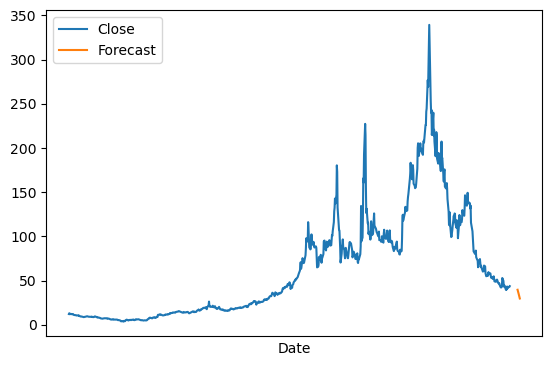

In [94]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim(month_ago,next_week)

In [95]:
fig3 = make_subplots(specs=[[{"secondary_y": True}]])
fig3.add_trace(go.Scatter(x=forecast_df.index,y=forecast_df['Forecast'],name='Forecast'))
fig3.add_trace(go.Scatter(x=df.index,y=df['Close'],name='Close'))
fig3.update_layout(title={'text':'Natural Gas TTF Predictions', 'x':0.5})
fig3.update_yaxes(range=[0,1000000000],secondary_y=True)
fig3.update_yaxes(visible=False, secondary_y=True)
fig3.update_layout(xaxis_rangeslider_visible=False)  #hide range slider
fig3.show()